# Sri Lanka Dengue Fever Analysis

##### Mathew Rajath Thomson

--- 

### Loading the datasets

In [3]:
# Import necessary libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import sys
import os

# Import libraries for statistical modeling
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import imageio.v2 as imageio
from IPython.display import Image, display
from matplotlib.lines import Line2D

# Import libraries for logging and warnings
import logging
import warnings
from typing import Optional, Dict
from colorama import Fore, Back, Style

# Set logging level for Matplotlib and PIL
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL').setLevel(logging.WARNING)

# Suppress matplotlib font manager debug messages
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module='seaborn.utils')
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib.axes._base')
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib.colorbar')

# Set up inline plotting for Jupyter Notebooks
%matplotlib inline

# Load the datasets
geographic_data = pd.read_excel('Sri_Lanka_Expanded_Geographic_Data_by_District.xlsx')
population_data = pd.read_csv('population_data[2007-2023].csv')
dengue_data = pd.read_csv('Updated_Sri_lanka_dengue_cases_weather_weekly_2007_2024_.csv')

# Display the first few rows and data types for each dataset
print("Geographic Data:\n", geographic_data.head())
print("\nData Types:\n", geographic_data.dtypes)

print("\nPopulation Data:\n", population_data.head())
print("\nData Types:\n", population_data.dtypes)

print("\nDengue Data:\n", dengue_data.head())
print("\nData Types:\n", dengue_data.dtypes)

# Check for missing values in each dataset
print("\nMissing Values in Geographic Data:\n", geographic_data.isnull().sum())
print("\nMissing Values in Population Data:\n", population_data.isnull().sum())
print("\nMissing Values in Dengue Data:\n", dengue_data.isnull().sum())

Geographic Data:
   Province  District  Latitude  Longitude  Area (km²)  Population  \
0  Western   Colombo    6.9271    79.8612         699     2309809   
1  Western   Gampaha    7.0900    79.9980        1387     2294641   
2  Western  Kalutara    6.5836    79.9609        1606     1217260   
3  Central     Kandy    7.2906    80.6337        1940     1369899   
4  Central    Matale    7.4678    80.6212        1993      484531   

   Urbanization (%)       Climate Type    Major Rivers Major Cities/Towns  \
0                77   Tropical Monsoon    Kelani River            Colombo   
1                54   Tropical Monsoon  Attanagalu Oya            Negombo   
2                30   Tropical Monsoon      Kalu River           Kalutara   
3                35  Tropical Highland  Mahaweli River              Kandy   
4                25  Tropical Highland     Amban Ganga             Matale   

   ...                 Temperature and Humidity  \
0  ...          High temperature, high humidity   
1 

### Step 1: Data Quality and Integrity Checks

#### 1.1 Data Consistency
- **Cross-verify district names**: Ensure that district names are consistent across all datasets (geographic, population, and dengue).
- **Check geographic coordinates**: Ensure that the latitude and longitude match the districts appropriately.
- **Temporal records**: Ensure that the dates align correctly across datasets.

##### Cross-verify district names

In [4]:
class ColoredFormatter(logging.Formatter):
    """Colored log formatter."""

    def __init__(self, *args, colors: Optional[Dict[str, str]] = None, **kwargs) -> None:
        """Initialize the formatter with specified format strings."""
        super().__init__(*args, **kwargs)
        self.colors = colors if colors else {}

    def format(self, record) -> str:
        """Format the specified record as text."""
        record.color = self.colors.get(record.levelname, '')
        record.reset = Style.RESET_ALL
        return super().format(record)

# Set up the colored formatter
formatter = ColoredFormatter(
    '{asctime} |{color} {levelname:8} {reset}| {name} | {message}',
    style='{', datefmt='%Y-%m-%d %H:%M:%S',
    colors={
        'DEBUG': Fore.CYAN,
        'INFO': Fore.GREEN,
        'WARNING': Fore.YELLOW,
        'ERROR': Fore.RED,
        'CRITICAL': Fore.RED + Back.WHITE + Style.BRIGHT,
    }
)

handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(formatter)

# Set up the logger
logger = logging.getLogger()
logger.handlers[:] = []
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

# Function to check for district discrepancies between two datasets
def find_district_discrepancies(set1, set2, label1, label2):
    # Find discrepancies between two sets
    discrepancies_1_2 = set1 - set2
    discrepancies_2_1 = set2 - set1
    
    if discrepancies_1_2 or discrepancies_2_1:
        logger.warning(f"Discrepancies between {label1} and {label2}:")
        if discrepancies_1_2:
            logger.warning(f"  Districts in {label1} but not in {label2}: {sorted(discrepancies_1_2)}")
        if discrepancies_2_1:
            logger.warning(f"  Districts in {label2} but not in {label1}: {sorted(discrepancies_2_1)}")
    else:
        logger.info(f"No discrepancies between {label1} and {label2}.")

# Get unique district sets from each dataset
geo_districts = set(geographic_data['District'])
pop_districts = set(population_data['district'])
dengue_districts = set(dengue_data['District'])

# Check for discrepancies
find_district_discrepancies(geo_districts, pop_districts, "Geographic Data", "Population Data")
find_district_discrepancies(geo_districts, dengue_districts, "Geographic Data", "Dengue Data")
find_district_discrepancies(pop_districts, dengue_districts, "Population Data", "Dengue Data")

2024-09-09 14:41:11 | WARNING  | root | Discrepancies between Geographic Data and Population Data:
2024-09-09 14:41:11 | WARNING  | root |   Districts in Geographic Data but not in Population Data: ['Monaragala', 'Nuwara Eliya']
2024-09-09 14:41:11 | WARNING  | root |   Districts in Population Data but not in Geographic Data: ['Moneragala', 'NuwaraEliya']
2024-09-09 14:41:11 | WARNING  | root | Discrepancies between Geographic Data and Dengue Data:
2024-09-09 14:41:11 | WARNING  | root |   Districts in Geographic Data but not in Dengue Data: ['Nuwara Eliya']
2024-09-09 14:41:11 | WARNING  | root |   Districts in Dengue Data but not in Geographic Data: ['NuwaraEliya']
2024-09-09 14:41:11 | WARNING  | root | Discrepancies between Population Data and Dengue Data:
2024-09-09 14:41:11 | WARNING  | root |   Districts in Population Data but not in Dengue Data: ['Moneragala']
2024-09-09 14:41:11 | WARNING  | root |   Districts in Dengue Data but not in Population Data: ['Monaragala']


###### Fix District Discrepancies

In [5]:
def correct_district_names(data, column, corrections, dataset_name):
    """Correct district names in the specified column of the DataFrame."""
    discrepancies = {old: new for old, new in corrections.items() if old in data[column].values}
    changed_districts = []

    if discrepancies:
        for old_name, new_name in discrepancies.items():
            data[column] = data[column].replace(old_name, new_name)
            changed_districts.append((old_name, new_name))
            logger.info(f"{old_name} has been corrected to {new_name} in {dataset_name}.")  # Log specific corrections
    
    return changed_districts

# Define corrections to district names
corrections = {
    'Monaragala': 'Moneragala',
    'NuwaraEliya': 'Nuwara Eliya',
}

# Apply corrections and log updates for each dataset
correct_district_names(geographic_data, 'District', corrections, 'Geographic Data')
correct_district_names(population_data, 'district', corrections, 'Population Data')
correct_district_names(dengue_data, 'District', corrections, 'Dengue Data')

# Verify the changes with significant updates for all corrections
logger.info("Districts updated successfully:")

2024-09-09 14:41:11 | INFO     | root | Monaragala has been corrected to Moneragala in Geographic Data.
2024-09-09 14:41:11 | INFO     | root | NuwaraEliya has been corrected to Nuwara Eliya in Population Data.
2024-09-09 14:41:12 | INFO     | root | Monaragala has been corrected to Moneragala in Dengue Data.
2024-09-09 14:41:12 | INFO     | root | NuwaraEliya has been corrected to Nuwara Eliya in Dengue Data.
2024-09-09 14:41:12 | INFO     | root | Districts updated successfully:


##### Geographic Coordinates Check
This will check if the geographic coordinates are within reasonable bounds (latitude: -90 to 90, longitude: -180 to 180):

In [6]:
# Create a logger
logger = logging.getLogger('coordinate_validator')
logger.setLevel(logging.INFO)

def validate_coordinates(data, lat_col='Latitude', lon_col='Longitude'):
    lat_valid = data[lat_col].between(-90, 90)
    lon_valid = data[lon_col].between(-180, 180)

    invalid_lat = data[~lat_valid]
    invalid_lon = data[~lon_valid]

    if not invalid_lat.empty:
        logger.error("Invalid Latitude Entries:\n%s", invalid_lat)
    else:
        logger.info("No invalid latitude entries found.")
    if not invalid_lon.empty:
        logger.error("Invalid Longitude Entries:\n%s", invalid_lon) 
    else:
        logger.info("No invalid longitude entries found.")

validate_coordinates(geographic_data)

2024-09-09 14:41:12 | INFO     | coordinate_validator | No invalid latitude entries found.
2024-09-09 14:41:12 | INFO     | coordinate_validator | No invalid longitude entries found.


##### Temporal Records Alignment
This will check if the years in your population and dengue datasets are consistent with the years present. 

In [7]:
# Checking for temporal consistency between population and dengue datasets
def check_temporal_consistency(population_data, dengue_data):
    # Extract unique years from both datasets
    years_pop = set(population_data['year'].unique())
    years_dengue = set(dengue_data['Year'].unique())

    logger.info("Starting temporal consistency check between Population and Dengue data.")

    # Log years present in each dataset
    logger.info("Years available in Population Data: %s", sorted(years_pop))
    logger.info("Years available in Dengue Data: %s", sorted(years_dengue))

    # Identify years that are in one dataset but not in the other
    years_in_pop_not_dengue = years_pop - years_dengue
    years_in_dengue_not_pop = years_dengue - years_pop

    # Report discrepancies
    if years_in_pop_not_dengue:
        logger.warning("Discrepancy: Years in Population Data but not in Dengue Data: %s", sorted(years_in_pop_not_dengue))
    else:
        logger.info("All Population Data years are accounted for in Dengue Data.")

    if years_in_dengue_not_pop:
        logger.warning("Discrepancy: Years in Dengue Data but not in Population Data: %s", sorted(years_in_dengue_not_pop))
    else:
        logger.info("All Dengue Data years are accounted for in Population Data.")

    # Summary of the check
    if not years_in_pop_not_dengue and not years_in_dengue_not_pop:
        logger.info("Temporal consistency check passed: No discrepancies found.")
    else:
        logger.warning("Temporal consistency check completed: Discrepancies detected.")

check_temporal_consistency(population_data, dengue_data)

2024-09-09 14:41:12 | INFO     | coordinate_validator | Starting temporal consistency check between Population and Dengue data.
2024-09-09 14:41:12 | INFO     | coordinate_validator | Years available in Population Data: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
2024-09-09 14:41:12 | INFO     | coordinate_validator | Years available in Dengue Data: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
2024-09-09 14:41:12 | INFO     | coordinate_validator | All Population Data years are accounted for in Dengue Data.
2024-09-09 14:41:12 | WARNING  | coordinate_validator | Discrepancy: Years in Dengue Data but not in Population Data: [2024]
2024-09-09 14:41:12 | WARNING  | coordinate_validator | Temporal consistency check completed: Discrepancies detected.


###### Fix Temporal Alignment

In [8]:
def predict_missing_population_for_district(population_data, district, missing_years):
    logger.info("Starting population prediction for district %s and missing years.", district)

    # Filter data for the specific district
    district_data = population_data[population_data['district'] == district]

    # Extract the years and population values for training
    X_train = np.array(district_data['year']).reshape(-1, 1)
    y_train = np.array(district_data['total_population'])

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Convert the set of missing years to a sorted list
    missing_years_list = sorted(list(missing_years))

    # Predict population for the missing years
    X_predict = np.array(missing_years_list).reshape(-1, 1)
    y_predict = model.predict(X_predict)

    # Create a dataframe for the predicted values
    predicted_population = pd.DataFrame({
        'year': missing_years_list,
        'total_population': y_predict,
        'district': district
    })

    logger.info("Predicted population for district %s for years: %s", district, missing_years_list)
    
    return predicted_population

def fix_temporal_alignment_with_prediction(population_data, dengue_data):
    logger.info("Starting temporal alignment with population prediction.")

    # Extract unique years from both datasets
    years_pop = set(population_data['year'].unique())
    years_dengue = set(dengue_data['Year'].unique())

    # Log current years in both datasets
    logger.info("Initial years in Population Data: %s", sorted(years_pop))
    logger.info("Initial years in Dengue Data: %s", sorted(years_dengue))

    # Identify missing years in Population Data
    missing_years_in_pop = years_dengue - years_pop

    # Store predictions for all districts
    all_predicted_data = []

    if missing_years_in_pop:
        logger.info("Missing years in Population Data: %s", sorted(missing_years_in_pop))
        
        # Loop through each district and predict the missing population data for the required years
        for district in population_data['district'].unique():
            predicted_population = predict_missing_population_for_district(population_data, district, missing_years_in_pop)
            all_predicted_data.append(predicted_population)

        # Concatenate all district predictions into a single dataframe
        predicted_population_data = pd.concat(all_predicted_data, ignore_index=True)
        
        # Append the predicted population data to the original dataset
        population_data = pd.concat([population_data, predicted_population_data], ignore_index=True)
        population_data = population_data.sort_values(by=['district', 'year'])

        # Log the updated population data
        logger.info("Updated Population Data with predictions.")
    else:
        logger.info("No missing years in Population Data.")

    # Perform temporal alignment after prediction
    aligned_population_data = population_data[population_data['year'].isin(years_dengue)]
    aligned_dengue_data = dengue_data[dengue_data['Year'].isin(years_dengue)]
    
    logger.info("Temporal alignment completed.")
    return aligned_population_data, aligned_dengue_data

aligned_population_data, aligned_dengue_data = fix_temporal_alignment_with_prediction(population_data, dengue_data)

2024-09-09 14:41:13 | INFO     | coordinate_validator | Starting temporal alignment with population prediction.
2024-09-09 14:41:13 | INFO     | coordinate_validator | Initial years in Population Data: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
2024-09-09 14:41:13 | INFO     | coordinate_validator | Initial years in Dengue Data: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
2024-09-09 14:41:13 | INFO     | coordinate_validator | Missing years in Population Data: [2024]
2024-09-09 14:41:13 | INFO     | coordinate_validator | Starting population prediction for district Colombo and missing years.
2024-09-09 14:41:13 | INFO     | coordinate_validator | Predicted population for district Colombo for years: [2024]
2024-09-09 14:41:13 | INFO     | coordinate_validator | Starting population prediction for district Gampaha and missing years.
2024-09-09 14:41:13 | INFO     | 

In [9]:
# Check the number of unique years in each dataset
print("Unique Years in Population Data:", population_data['year'].unique())
print("Unique Years in Dengue Data:", dengue_data['Year'].unique())

Unique Years in Population Data: [2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022 2023]
Unique Years in Dengue Data: [2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022 2023 2024]


In [10]:
# Check the number of unique years in each dataset
print("Unique Years in Population Data:", aligned_population_data['year'].unique())
print("Unique Years in Dengue Data:", aligned_dengue_data['Year'].unique())

Unique Years in Population Data: [2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022 2023 2024]
Unique Years in Dengue Data: [2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022 2023 2024]


In [11]:
population_data = aligned_population_data
dengue_data = aligned_dengue_data

#### 1.2 Data Types and Encoding
- **Validate data types**: Check if the data types are appropriate for each column (numerical, categorical, date-time).
- **Check for missing values and duplicates**: Identify any missing entries or duplicate rows.

##### Validate data types
Ensure the data types are correct for each column (e.g., categorical, numerical, datetime, etc.).

In [12]:
# Check data types for each dataset
print(geographic_data.dtypes)
print(population_data.dtypes)
print(dengue_data.dtypes)

Province                                                        object
District                                                        object
Latitude                                                       float64
Longitude                                                      float64
Area (km²)                                                       int64
Population                                                       int64
Urbanization (%)                                                 int64
Climate Type                                                    object
Major Rivers                                                    object
Major Cities/Towns                                              object
Land Use (% Forest)                                            float64
Land Use (% Agriculture)                                       float64
Land Use (% Urban)                                             float64
Population Density (people/km²)                                  int64
Averag

###### Data Types Assessment Summary

- **Categorical Variables**: Most columns like `Province`, `District`, `Climate Type`, and `Natural Disasters` are correctly classified as `object`, reflecting their categorical nature.
- **Numerical Variables**: Columns representing counts and measurements (e.g., `Population`, `Area`, `Number of Cases`) are mostly assigned to `int64`, which is appropriate. However, some percentage columns (e.g., `Urbanization (%)`, `Land Use (%)`) and density metrics could be better represented as `float64` to accommodate decimal values.
- **Geospatial Data**: Latitude and Longitude are correctly classified as `float64`. 
- **Date Columns**: Columns representing dates (e.g., `Week_Start_Date`, `Week_End_Date`) should be converted to `datetime` for better handling in analyses.
- **Temperature and Weather Data**: Variables such as average temperatures and precipitation are rightly marked as `float64`

###### Things to do:
1. **Convert date-related columns to `datetime` type**
2. **Remove Unwanted Columns when merging**

###### Convert date-related columns to datetime type:

In [13]:
# Convert date columns in dengue_data to datetime
dengue_data['Week_Start_Date'] = pd.to_datetime(dengue_data['Week_Start_Date'], errors='coerce')
dengue_data['Week_End_Date'] = pd.to_datetime(dengue_data['Week_End_Date'], errors='coerce')

# Print the data types again to confirm the changes
print(dengue_data.dtypes)

District                                 object
Number_of_Cases                           int64
Week_Start_Date                  datetime64[ns]
Month                                     int64
Year                                      int64
Week                                      int64
Week_End_Date                    datetime64[ns]
Avg Max Temp (°C)                       float64
Avg Min Temp (°C)                       float64
Avg Apparent Max Temp (°C)              float64
Avg Apparent Min Temp (°C)              float64
Total Precipitation (mm)                float64
Total Rain (mm)                         float64
Avg Wind Speed (km/h)                   float64
Max Wind Gusts (km/h)                   float64
Weather Code                              int64
Avg Daylight Duration (hours)           float64
Avg Sunrise Time                          int64
Avg Sunset Time                           int64
dtype: object


##### Check for missing values and duplicates

###### Check for missing values in each dataset


In [14]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to check for missing values in a DataFrame
def check_missing_values(df, df_name):
    missing_values = df.isnull().sum()
    total_missing = missing_values.sum()
    
    if total_missing > 0:
        logging.warning(f"Missing values in {df_name}:")
        for column, count in missing_values[missing_values > 0].items():
            logging.warning(f"  {column}: {count} missing")
    else:
        logging.info(f"No missing values in {df_name}.")

# Check for missing values in each dataset
check_missing_values(geographic_data, "Geographic Data")
check_missing_values(population_data, "Population Data")
check_missing_values(dengue_data, "Dengue Data")

2024-09-09 14:41:15 | INFO     | root | No missing values in Geographic Data.
2024-09-09 14:41:15 | INFO     | root | No missing values in Population Data.
2024-09-09 14:41:15 | INFO     | root | No missing values in Dengue Data.


###### Check for Duplicates

In [15]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to check for duplicates in a DataFrame
def count_duplicates(df):
    """Count the number of duplicate rows in a DataFrame."""
    return df.duplicated().sum()

def log_duplicates(duplicates, df_name):
    """Log the duplicate rows found in a DataFrame."""
    if not duplicates.empty:
        logging.warning(f"Found {len(duplicates)} duplicate rows in {df_name}.")
        logging.warning(f"\n{duplicates}\n")  # Log the duplicate rows
    return len(duplicates) > 0

def check_duplicates(df, df_name):
    """Check for duplicates in a DataFrame and log the results."""
    if df is None or df.empty:
        logging.error(f"The DataFrame for {df_name} is invalid or empty.")
        return None

    duplicate_count = count_duplicates(df)

    # Log a single message for duplicate count and presence
    if duplicate_count > 0:
        logging.info(f"{df_name} has {duplicate_count} duplicate rows.")
        duplicates = df[df.duplicated(keep=False)]
        log_duplicates(duplicates, df_name)
    else:
        logging.info(f"{df_name} has no duplicates.")

# Check for duplicates in each dataset
check_duplicates(geographic_data, "Geographic Data")
check_duplicates(population_data, "Population Data")
check_duplicates(dengue_data, "Dengue Data")

2024-09-09 14:41:16 | INFO     | root | Geographic Data has no duplicates.
2024-09-09 14:41:16 | INFO     | root | Population Data has no duplicates.
2024-09-09 14:41:16 | INFO     | root | Dengue Data has no duplicates.


#### 1.3 Outlier Detection
- **Outlier detection methods**: tbd later

## Merge the datasets for analysis:

In [16]:
# Check for missing values in all datasets
print(geographic_data.isnull().sum())
print(population_data.isnull().sum())
print(dengue_data.isnull().sum())

Province                                                       0
District                                                       0
Latitude                                                       0
Longitude                                                      0
Area (km²)                                                     0
Population                                                     0
Urbanization (%)                                               0
Climate Type                                                   0
Major Rivers                                                   0
Major Cities/Towns                                             0
Land Use (% Forest)                                            0
Land Use (% Agriculture)                                       0
Land Use (% Urban)                                             0
Population Density (people/km²)                                0
Average Annual Rainfall (mm)                                   0
Temperature Range (°C)   

In [17]:
# Normalize district names (remove extra spaces and lower case)
geographic_data['District'] = geographic_data['District'].str.strip().str.lower()
population_data['district'] = population_data['district'].str.strip().str.lower()
dengue_data['District'] = dengue_data['District'].str.strip().str.lower()

In [18]:
# Merge geographic data with dengue weather data
merged_geo_dengue = pd.merge(geographic_data, dengue_data, on='District', how='outer')

# Merge population data (by Year and District)
final_data = pd.merge(merged_geo_dengue, population_data, left_on=['District', 'Year'], right_on=['district', 'year'], how='outer')

# Check the results
print(final_data.shape)
print(final_data.isnull().sum())

(22900, 51)
Province                                                       0
District                                                       0
Latitude                                                       0
Longitude                                                      0
Area (km²)                                                     0
Population                                                     0
Urbanization (%)                                               0
Climate Type                                                   0
Major Rivers                                                   0
Major Cities/Towns                                             0
Land Use (% Forest)                                            0
Land Use (% Agriculture)                                       0
Land Use (% Urban)                                             0
Population Density (people/km²)                                0
Average Annual Rainfall (mm)                                   0
Temperature R

In [19]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Display the first few rows of the dataset
final_data.head()

Province District  Latitude  Longitude  Area (km²)  Population  \
0  Eastern   ampara       7.3       81.7        4415      648057   
1  Eastern   ampara       7.3       81.7        4415      648057   
2  Eastern   ampara       7.3       81.7        4415      648057   
3  Eastern   ampara       7.3       81.7        4415      648057   
4  Eastern   ampara       7.3       81.7        4415      648057   

   Urbanization (%)      Climate Type Major Rivers Major Cities/Towns  \
0                10  Tropical Monsoon      Gal Oya             Ampara   
1                10  Tropical Monsoon      Gal Oya             Ampara   
2                10  Tropical Monsoon      Gal Oya             Ampara   
3                10  Tropical Monsoon      Gal Oya             Ampara   
4                10  Tropical Monsoon      Gal Oya             Ampara   

   Land Use (% Forest)  Land Use (% Agriculture)  Land Use (% Urban)  \
0                 37.5                      22.7                 5.0   
1                 37.5                      22.7                 5.0   
2                 37.5                      22.7                 5.0   
3                 37.5                      22.7                 5.0   
4                 37.5                      22.7                 5.0   

   Population Density (people/km²)  Average Annual Rainfall (mm)  \
0                              147                          1400   
1                              147                          1400   
2                              147                          1400   
3                              147                          1400   
4                              147                          1400   

  Temperature Range (°C) Natural Disasters  \
0                  25-35  Floods, Droughts   
1                  25-35  Floods, Droughts   
2                  25-35  Floods, Droughts   
3                  25-35  Floods, Droughts   
4                  25-35  Floods, Droughts   

   Dengue Incidence Rate (per 100,000)         Mosquito Breeding Sites  \
0                                  140  Water containers, paddy fields   
1                                  140  Water containers, paddy fields   
2                                  140  Water containers, paddy fields   
3                                  140  Water containers, paddy fields   
4                                  140  Water containers, paddy fields   

                        Rainfall Patterns         Temperature and Humidity  \
0  Moderate rainfall, seasonal variations  High temperature, high humidity   
1  Moderate rainfall, seasonal variations  High temperature, high humidity   
2  Moderate rainfall, seasonal variations  High temperature, high humidity   
3  Moderate rainfall, seasonal variations  High temperature, high humidity   
4  Moderate rainfall, seasonal variations  High temperature, high humidity   

  Public Health Infrastructure   Water Storage Practices  \
0         Limited, rural focus  Common, rural households   
1         Limited, rural focus  Common, rural households   
2         Limited, rural focus  Common, rural households   
3         Limited, rural focus  Common, rural households   
4         Limited, rural focus  Common, rural households   

             Population Mobility Vector Control Measures  \
0  Moderate, occasional movement      Occasional fogging   
1  Moderate, occasional movement      Occasional fogging   
2  Moderate, occasional movement      Occasional fogging   
3  Moderate, occasional movement      Occasional fogging   
4  Moderate, occasional movement      Occasional fogging   

         Waste Management  Number of Campaigns (last 5 years) Focus Areas  \
0  Limited, rural-focused                                  15   Awareness   
1  Limited, rural-focused                                  15   Awareness   
2  Limited, rural-focused                                  15   Awareness   
3  Limited, rural-focused                                  15   Awareness   
4  Limited, ru

In [20]:
# Check data types and unique values of each column
data_info = final_data.info()
data_unique_values = final_data.nunique()

data_info, data_unique_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22900 entries, 0 to 22899
Data columns (total 51 columns):
 #   Column                                                       Non-Null Count  Dtype         
---  ------                                                       --------------  -----         
 0   Province                                                     22900 non-null  object        
 1   District                                                     22900 non-null  object        
 2   Latitude                                                     22900 non-null  float64       
 3   Longitude                                                    22900 non-null  float64       
 4   Area (km²)                                                   22900 non-null  int64         
 5   Population                                                   22900 non-null  int64         
 6   Urbanization (%)                                             22900 non-null  int64         
 7   Climate Type 

(None,
 Province                                                          9
 District                                                         25
 Latitude                                                         25
 Longitude                                                        25
 Area (km²)                                                       25
 Population                                                       25
 Urbanization (%)                                                 13
 Climate Type                                                      6
 Major Rivers                                                     19
 Major Cities/Towns                                               25
 Land Use (% Forest)                                              25
 Land Use (% Agriculture)                                         25
 Land Use (% Urban)                                               22
 Population Density (people/km²)                                  24
 Average Annual Rainfall (m

In [21]:
# Generate summary statistics for numerical columns
summary_stats = final_data.describe()
summary_stats

Latitude     Longitude    Area (km²)    Population  \
count  22900.000000  22900.000000  22900.000000  2.290000e+04   
mean       7.580576     80.588560   2615.160000  8.176054e+05   
min        5.948500     79.843900    699.000000  9.194700e+04   
25%        6.927100     80.220000   1652.000000  4.717320e+05   
50%        7.300000     80.492500   1996.000000  7.053420e+05   
75%        8.311400     81.001600   3072.000000  1.088007e+06   
max        9.661500     81.700000   7179.000000  2.309809e+06   
std        1.038743      0.534257   1492.575324  5.803228e+05   

       Urbanization (%)  Land Use (% Forest)  Land Use (% Agriculture)  \
count      22900.000000         22900.000000              22900.000000   
mean          24.360000            27.204000                 35.360000   
min            8.000000             3.100000                 21.200000   
25%           12.000000            12.000000                 25.500000   
50%           20.000000            26.700000                 35.800000   
75%           30.000000            38.400000                 43.700000   
max           77.000000            59.800000                 51.400000   
std           15.796243            16.498275                 10.263401   

       Land Use (% Urban)  Population Density (people/km²)  \
count        22900.000000                      22900.00000   
mean            11.600000                        477.32000   
min              2.000000                         35.00000   
25%              5.400000                        120.00000   
50%              8.000000                        251.00000   
75%             12.400000                        569.00000   
max             45.000000                       3306.00000   
std             10.738055                        670.99052   

       Average Annual Rainfall (mm)  Dengue Incidence Rate (per 100,000)  \
count                  22900.000000                          22900.00000   
mean                    1956.000000                            216.40000   
min                      900.000000                             70.00000   
25%                     1400.000000                            130.00000   
50%                     1600.000000                            180.00000   
75%                     2400.000000                            270.00000   
max                     4000.000000                            520.00000   
std                      850.350267                            120.23174   

       Number of Campaigns (last 5 years)  \
count                        22900.000000   
mean                            12.880000   
min                              5.000000   
25%                              9.000000   
50%                             12.000000   
75%                             16.000000   
max                             25.000000   
std                              5.179457   

       Distance to Nearest Hospital/Clinic (km)  \
count                               22900.00000   
mean                                    8.82000   
min                                     2.00000   
25%                                     4.50000   
50%                                     7.00000   
75%                                    12.00000   
max                                    22.00000   
std                                     5.74622   

       Healthcare Facility Density (facilities per 100,000 people)  \
count                                       22900.000000             
mean                                            9.000000             
min                                             2.000000             
25%                                             6.000000             
50%                                             9.000000             
75%                                            12.000000             
max                                            18.000000             
std                                             4.516735             

       Number_of_

# Trend of dengue cases

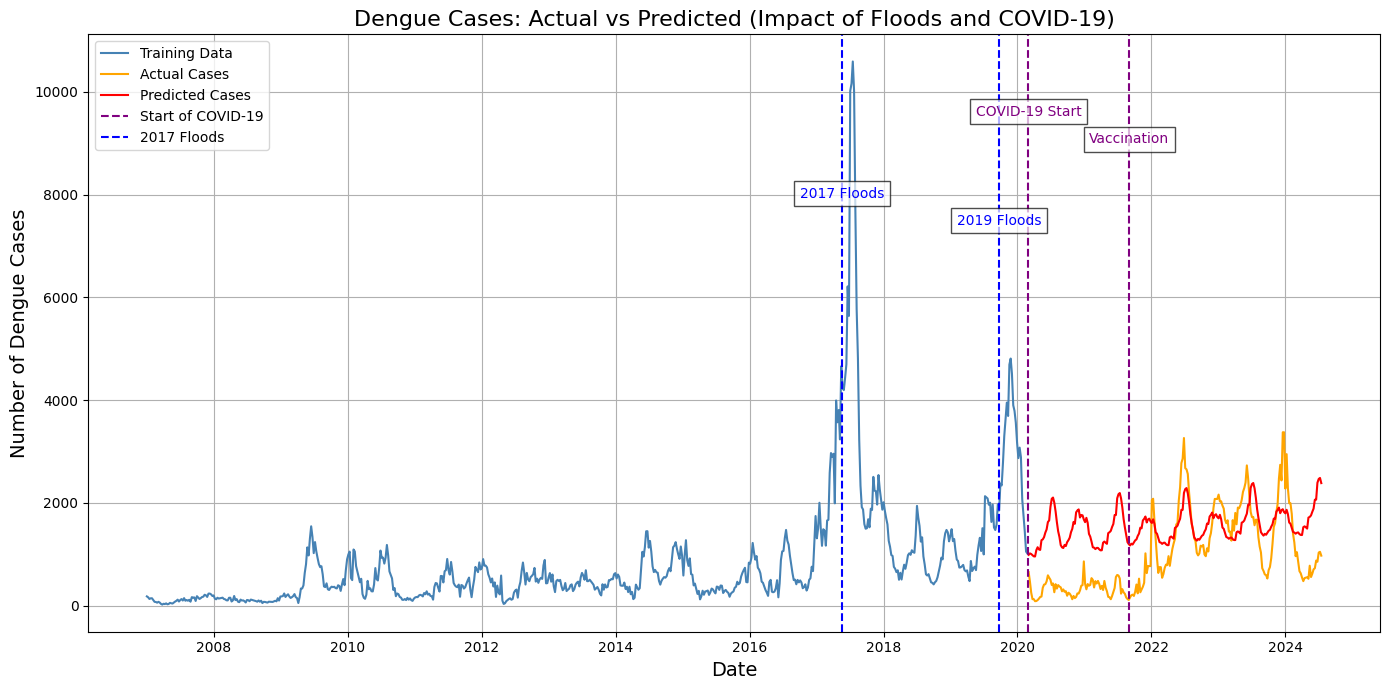

In [22]:
# Data Preparation
# ----------------
# Convert 'Week_Start_Date' to datetime format for proper time series analysis
final_data['Week_Start_Date'] = pd.to_datetime(final_data['Week_Start_Date'])

# Group data by week and aggregate the number of dengue cases
weekly_cases = final_data.groupby(['Week_Start_Date'])['Number_of_Cases'].sum().reset_index()

# Splitting the data
# ------------------
# Filter data into training (before March 2020) and test sets (March 2020 onwards)
train_data = weekly_cases[weekly_cases['Week_Start_Date'] < '2020-03-01']
test_data = weekly_cases[weekly_cases['Week_Start_Date'] >= '2020-03-01']

# Set the 'Week_Start_Date' as index for SARIMA modeling
train_data.set_index('Week_Start_Date', inplace=True)
test_data.set_index('Week_Start_Date', inplace=True)

train_data.index = pd.date_range(start=train_data.index[0], periods=len(train_data), freq='W-MON')
test_data.index = pd.date_range(start=test_data.index[0], periods=len(test_data), freq='W-MON')

# SARIMA Model Training
# ---------------------
# Define the SARIMA model (with seasonal order set to account for yearly patterns)
model = SARIMAX(train_data['Number_of_Cases'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))

# Suppress warnings during model fitting
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model_fit = model.fit(disp=False, maxiter=1000)

# Model Prediction
# ----------------
# Generate predictions for the test set based on the trained model
predictions = model_fit.forecast(steps=len(test_data))

# Visualization: Actual vs Predicted Cases
# ----------------------------------------
plt.figure(figsize=(14, 7))

# Plot training data (actual cases before 2020-03-01)
plt.plot(train_data.index, train_data['Number_of_Cases'], label='Training Data', color='steelblue')

# Plot test data (actual cases from 2020-03-01 onward)
plt.plot(test_data.index, test_data['Number_of_Cases'], label='Actual Cases', color='orange')

# Plot predicted cases (for the test period)
plt.plot(test_data.index, predictions, label='Predicted Cases', color='red')

# Mark Significant Events (COVID-19 and Floods)
# ---------------------------------------------
# COVID-19 related events
plt.axvline(x=pd.to_datetime('2020-03-01'), color='purple', linestyle='--', label='Start of COVID-19')
plt.text(pd.to_datetime('2020-03-01'), max(weekly_cases['Number_of_Cases']) * 0.9, 'COVID-19 Start', 
         rotation=0, color='purple', fontsize=10, ha='center', bbox=dict(facecolor='white', alpha=0.7))

plt.axvline(x=pd.to_datetime('2021-09-01'), color='purple', linestyle='--')
plt.text(pd.to_datetime('2021-09-01'), max(weekly_cases['Number_of_Cases']) * 0.85, 'Vaccination', 
         rotation=0, color='purple', fontsize=10, ha='center', bbox=dict(facecolor='white', alpha=0.7))

# Flood related events
plt.axvline(x=pd.to_datetime('2017-05-18'), color='blue', linestyle='--', label='2017 Floods')
plt.text(pd.to_datetime('2017-05-18'), max(weekly_cases['Number_of_Cases']) * 0.75, '2017 Floods', 
         rotation=0, color='blue', fontsize=10, ha='center', bbox=dict(facecolor='white', alpha=0.7))

plt.axvline(x=pd.to_datetime('2019-09-24'), color='blue', linestyle='--')
plt.text(pd.to_datetime('2019-09-24'), max(weekly_cases['Number_of_Cases']) * 0.7, '2019 Floods', 
         rotation=0, color='blue', fontsize=10, ha='center', bbox=dict(facecolor='white', alpha=0.7))

# Plot Customization and Enhancements
# -----------------------------------
# Add title and labels
plt.title('Dengue Cases: Actual vs Predicted (Impact of Floods and COVID-19)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Dengue Cases', fontsize=14)

# Display legend in the upper left corner
plt.legend(loc='upper left', fontsize=10)

# Rotate x-axis labels
plt.xticks(rotation=0)

# Optimize the layout
plt.tight_layout()

# Add grid
plt.grid()

# Show the final plot
plt.show()



**Insight**:  
This time series analysis forecasts dengue cases using the SARIMA model, revealing predicted versus actual cases over time. The model captures weekly trends and seasonality in dengue incidence, with notable deviations during significant external events:

1. **COVID-19 Pandemic (March 2020)**: The pandemic resulted in disruptions to typical dengue transmission patterns. Factors such as lockdowns, changes in healthcare priorities, and decreased human mobility likely contributed to the divergence between predicted and actual dengue cases during this period.
   
2. **Vaccination Rollout (September 2021)**: The introduction of COVID-19 vaccines and shifts in public health resources may have indirectly affected the response to dengue outbreaks. This change in resource allocation could influence future dengue control measures and predi And also  marks the end of lockdowns.ctions.

3. **Floods (May 2017 & September 2019)**: Flooding events often lead to increased mosquito breeding sites, directly affecting dengue transmission. This correlation between floods and dengue case spikes highlights the need to account for environmental events in disease forecasting models.

---

**Modeling Considerations**:  
These events emphasize the importance of incorporating **external factors** when modeling infectious disease transmission. Here's why they matter:

- **Pandemics** and other public health crises can drastically alter disease transmission patterns by changing human behavior, healthcare focus, and resource availability. Including such factors in models can improve predictive accuracy during unprecedented disruptions.
  
- **Environmental factors**, such as floods and climate conditions, are critical to vector-borne diseases like dengue. Rainfall and temperature influence mosquito breeding cycles, so models should account for climate variability and extreme weather events to enhance predictions.

- **Policy Changes**, such as the rollouts of vaccines or public health interventions, directly influence the effectiveness of disease control. Ignoring these in models could lead to under- or over-estimatiaordinary circumstances.

# Dengue Cases per 100,000 Population by District: Yearly, Monthly, and Weekly Trends with Urbanization Levels

## Yearly Heatmap:

2024-09-09 14:42:46 | DEBUG    | matplotlib.colorbar | locator: <matplotlib.ticker.AutoLocator object at 0x000002036CFB6AC0>
2024-09-09 14:42:46 | DEBUG    | matplotlib.axes._base | title position was updated manually, not adjusting
2024-09-09 14:42:46 | DEBUG    | matplotlib.axes._base | title position was updated manually, not adjusting
2024-09-09 14:42:46 | DEBUG    | matplotlib.axes._base | title position was updated manually, not adjusting
2024-09-09 14:42:46 | DEBUG    | matplotlib.axes._base | title position was updated manually, not adjusting


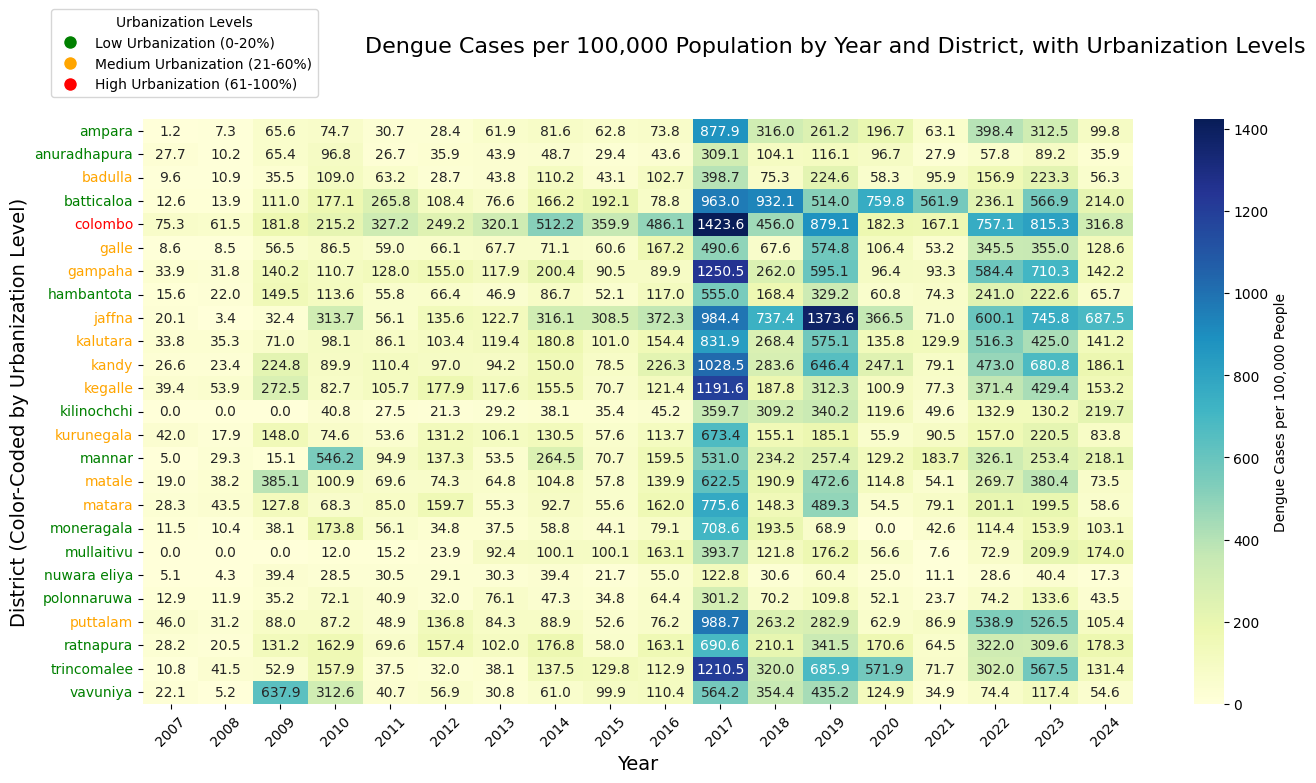

In [23]:
# Step 1: Aggregate total cases by District and Year
total_cases_by_year_district = final_data.groupby(['District', 'Year'])['Number_of_Cases'].sum().reset_index()

# Get total population by district and year
population_by_year_district = final_data.groupby(['District', 'Year'])['Population'].first().reset_index()

# Get urbanization data by district and year
urbanization_by_year_district = final_data.groupby(['District', 'Year'])['Urbanization (%)'].first().reset_index()

# Step 2: Merge cases, population, and urbanization
merged_data = pd.merge(total_cases_by_year_district, population_by_year_district, on=['District', 'Year'])
merged_data = pd.merge(merged_data, urbanization_by_year_district, on=['District', 'Year'])

# Step 3: Calculate cases per 100,000 people
merged_data['Cases_per_100k'] = (merged_data['Number_of_Cases'] / merged_data['Population']) * 100000

# Step 4: Pivot the data for the heatmap
heatmap_data = merged_data.pivot(index='District', columns='Year', values='Cases_per_100k')

# Step 5: Create the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlGnBu', cbar_kws={'label': 'Dengue Cases per 100,000 People'})

# plot
plt.title('Dengue Cases per 100,000 Population by Year and District, with Urbanization Levels', fontsize=16, x= 0.7, y= 1.1)
plt.xlabel('Year', fontsize=14)
plt.ylabel('District (Color-Coded by Urbanization Level)', fontsize=14)
plt.xticks(rotation=45)

# Add color to district names based on urbanization
urbanization_values = merged_data.groupby('District')['Urbanization (%)'].first()
y_labels = heatmap_data.index.tolist()

# y-tick positions and colors
for i, district in enumerate(y_labels):
    urbanization_value = urbanization_values[district]
    
    # Set text color based on urbanization
    if urbanization_value <= 20:
        text_color = 'green'
    elif urbanization_value <= 60:
        text_color = 'orange'
    else:
        text_color = 'red'
    
    # Update y-tick labels with color
    tick_label = plt.gca().get_yticklabels()[i]
    tick_label.set_color(text_color)
    tick_label.set_y(tick_label.get_position()[1] - 0.2)

# legend for urbanization
legend_labels = ['Low Urbanization (0-20%)', 'Medium Urbanization (21-60%)', 'High Urbanization (61-100%)']
legend_colors = ['green', 'orange', 'red']

# Create legend handles and labels
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                              markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, legend_colors)]

# Place the legend on the plot
plt.legend(handles=legend_handles, title='Urbanization Levels', loc='upper left', bbox_to_anchor=(-0.1, 1.2))

plt.tight_layout()
plt.show()

## Monthly Heatmap:

2024-09-09 14:42:47 | DEBUG    | matplotlib.colorbar | locator: <matplotlib.ticker.AutoLocator object at 0x000002036DC931F0>
2024-09-09 14:42:47 | DEBUG    | matplotlib.axes._base | title position was updated manually, not adjusting
2024-09-09 14:42:47 | DEBUG    | matplotlib.axes._base | title position was updated manually, not adjusting
2024-09-09 14:42:47 | DEBUG    | matplotlib.axes._base | title position was updated manually, not adjusting
2024-09-09 14:42:47 | DEBUG    | matplotlib.axes._base | title position was updated manually, not adjusting


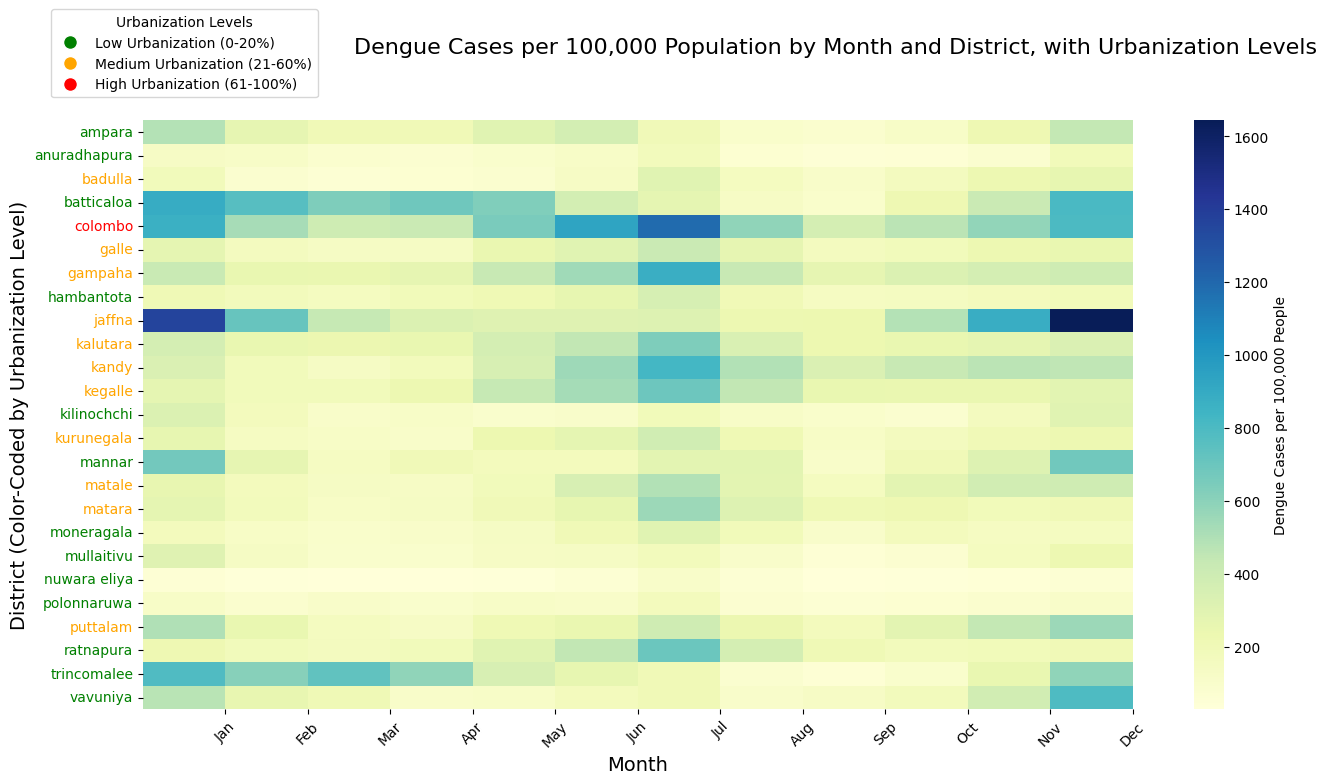

In [24]:
# Step 1: Aggregate total cases by District and Month (across all years)
total_cases_by_month_district = final_data.groupby(['District', 'Month'])['Number_of_Cases'].sum().reset_index()

# Step 2: Get total population by district and month (first population entry for each month)
population_by_month_district = final_data.groupby(['District', 'Month'])['Population'].first().reset_index()

# Step 3: Get urbanization data by district and month (first urbanization entry for each month)
urbanization_by_month_district = final_data.groupby(['District', 'Month'])['Urbanization (%)'].first().reset_index()

# Step 4: Merge cases, population, and urbanization
merged_month_data = pd.merge(total_cases_by_month_district, population_by_month_district, on=['District', 'Month'])
merged_month_data = pd.merge(merged_month_data, urbanization_by_month_district, on=['District', 'Month'])

# Step 5: Calculate cases per 100,000 people
merged_month_data['Cases_per_100k'] = (merged_month_data['Number_of_Cases'] / merged_month_data['Population']) * 100000

# Step 6: Pivot the data for the heatmap
heatmap_month_data = merged_month_data.pivot(index='District', columns='Month', values='Cases_per_100k')

# Step 7: Create the heatmap for monthly aggregation
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_month_data, annot=False, cmap='YlGnBu', cbar_kws={'label': 'Dengue Cases per 100,000 People'})

# plot
plt.title('Dengue Cases per 100,000 Population by Month and District, with Urbanization Levels', fontsize=16, x=0.7, y=1.1)
plt.xlabel('Month', fontsize=14)
plt.ylabel('District (Color-Coded by Urbanization Level)', fontsize=14)

# Set x-ticks to display month names
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

# Add color to district names based on urbanization
urbanization_values = merged_month_data.groupby('District')['Urbanization (%)'].first()
y_labels = heatmap_month_data.index.tolist()

# y-tick positions and colors
for i, district in enumerate(y_labels):
    urbanization_value = urbanization_values[district]
    
    # Set text color based on urbanization
    if urbanization_value <= 20:
        text_color = 'green'
    elif urbanization_value <= 60:
        text_color = 'orange'
    else:
        text_color = 'red'
    
    # Update y-tick labels with color
    tick_label = plt.gca().get_yticklabels()[i]
    tick_label.set_color(text_color)
    tick_label.set_y(tick_label.get_position()[1] - 0.2)

# Legend for urbanization
legend_labels = ['Low Urbanization (0-20%)', 'Medium Urbanization (21-60%)', 'High Urbanization (61-100%)']
legend_colors = ['green', 'orange', 'red']

# Create legend handles and labels
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                              markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, legend_colors)]

# Place the legend on the plot
plt.legend(handles=legend_handles, title='Urbanization Levels', loc='upper left', bbox_to_anchor=(-0.1, 1.2))

plt.tight_layout()
plt.show()

## Weekly Heatmap:

2024-09-09 16:32:18 | DEBUG    | matplotlib.colorbar | locator: <matplotlib.ticker.AutoLocator object at 0x00000203966980A0>
2024-09-09 16:32:18 | DEBUG    | matplotlib.axes._base | title position was updated manually, not adjusting
2024-09-09 16:32:18 | DEBUG    | matplotlib.axes._base | title position was updated manually, not adjusting
2024-09-09 16:32:18 | DEBUG    | matplotlib.axes._base | title position was updated manually, not adjusting
2024-09-09 16:32:18 | DEBUG    | matplotlib.axes._base | title position was updated manually, not adjusting


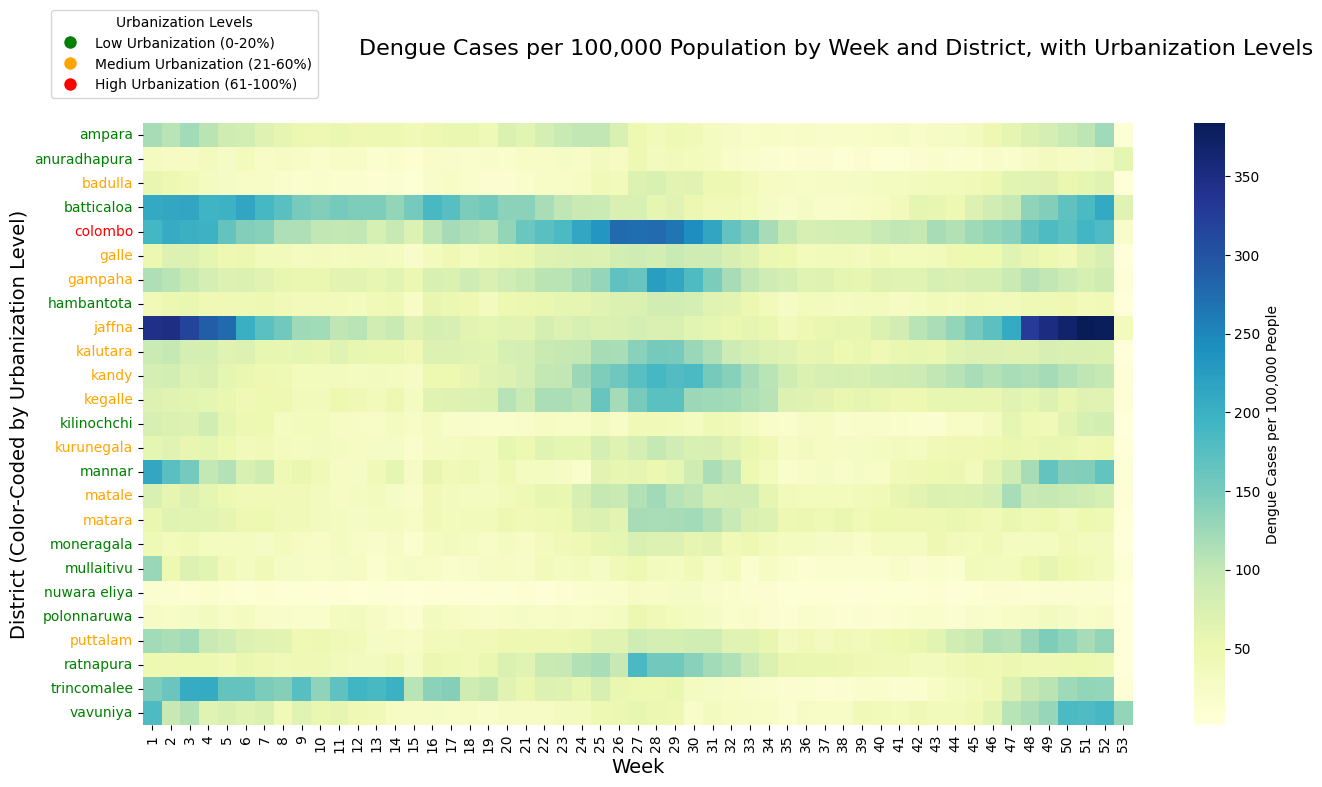

In [28]:
# Step 1: Aggregate total cases by District and Week (across all years)
total_cases_by_week_district = final_data.groupby(['District', 'Week'])['Number_of_Cases'].sum().reset_index()

# Step 2: Get total population by district and week (first population entry for each week)
population_by_week_district = final_data.groupby(['District', 'Week'])['Population'].first().reset_index()

# Step 3: Get urbanization data by district and week (first urbanization entry for each week)
urbanization_by_week_district = final_data.groupby(['District', 'Week'])['Urbanization (%)'].first().reset_index()

# Step 4: Merge cases, population, and urbanization
merged_week_data = pd.merge(total_cases_by_week_district, population_by_week_district, on=['District', 'Week'])
merged_week_data = pd.merge(merged_week_data, urbanization_by_week_district, on=['District', 'Week'])

# Step 5: Calculate cases per 100,000 people
merged_week_data['Cases_per_100k'] = (merged_week_data['Number_of_Cases'] / merged_week_data['Population']) * 100000

# Step 6: Pivot the data for the heatmap
heatmap_week_data = merged_week_data.pivot(index='District', columns='Week', values='Cases_per_100k')

# Step 7: Create the heatmap for weekly aggregation
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_week_data, annot=False, cmap='YlGnBu', cbar_kws={'label': 'Dengue Cases per 100,000 People'})

# plot
plt.title('Dengue Cases per 100,000 Population by Week and District, with Urbanization Levels', fontsize=16, x=0.7, y=1.1)
plt.xlabel('Week', fontsize=14)
plt.ylabel('District (Color-Coded by Urbanization Level)', fontsize=14)

# Add color to district names based on urbanization
urbanization_values = merged_week_data.groupby('District')['Urbanization (%)'].first()
y_labels = heatmap_week_data.index.tolist()

# y-tick positions and colors
for i, district in enumerate(y_labels):
    urbanization_value = urbanization_values[district]
    
    # Set text color based on urbanization
    if urbanization_value <= 20:
        text_color = 'green'
    elif urbanization_value <= 60:
        text_color = 'orange'
    else:
        text_color = 'red'
    
    # Update y-tick labels with color
    tick_label = plt.gca().get_yticklabels()[i]
    tick_label.set_color(text_color)
    tick_label.set_y(tick_label.get_position()[1] - 0.2)

# Legend for urbanization
legend_labels = ['Low Urbanization (0-20%)', 'Medium Urbanization (21-60%)', 'High Urbanization (61-100%)']
legend_colors = ['green', 'orange', 'red']

# Create legend handles and labels
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                              markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, legend_colors)]

# Place the legend on the plot
plt.legend(handles=legend_handles, title='Urbanization Levels', loc='upper left', bbox_to_anchor=(-0.1, 1.2))

plt.tight_layout()
plt.show()

### Insights:

1. **Urbanization and Dengue Cases:**
   - **High Urbanization Areas:** Districts with high urbanization, such as Colombo, consistently reported higher dengue cases across almost all years analyzed. This suggests a correlation between urbanization and increased risk of dengue transmission, likely due to higher population density, inadequate waste management, and potential mosquito breeding sites.
   - **Medium Urbanization Areas:** Districts with medium urbanization exhibited a similar trend but with fewer cases overall compared to high urbanization areas. This indicates that urbanization may still play a role in dengue incidence, though the impact is less pronounced.

2. **Monthly Trends:**
   - **Peak in June:** The analysis revealed that June is a common month for dengue cases across most districts. This could indicate seasonal factors affecting mosquito populations, such as rainfall and humidity, which may create ideal breeding conditions during this period.
   - **Exceptions:** A few districts, such as Jaffna and Mannar, exhibited extreme cases from November to January. This suggests that local factors may contribute to outbreaks during these months, potentially influenced by climate variations or public health interventions.

3. **Regional Variations:**
   - **Trincomalee and Batticaloa:** These districts showed a distinct pattern, with cases peaking from November to May. This may reflect unique environmental or socioeconomic factors influencing dengue transmission in these areas, warranting further investigation into local conditions and vector control measures.
  
To understand the exceptions—such as Jaffna, Mannar, Trincomalee, and Batticaloa—where dengue cases peak outside the common trend, we can consider several factors that might be contributing to their unique patterns.

##### 1. **Geographical Factors:**
   - **Climate and Weather Patterns:** 
     - Jaffna and Mannar are located in the northern part of Sri Lanka, where climate conditions may differ significantly from other regions. For example, the dry and wet seasons may vary, affecting mosquito breeding habits.
     - Trincomalee and Batticaloa, located on the eastern coast, might have different rainfall patterns that create conducive environments for mosquito breeding during the months of November to May.

##### 2. **Local Ecology:**
   - **Breeding Sites:** 
     - The presence of natural and artificial water bodies in these districts can influence mosquito breeding. Areas with stagnant water or poor drainage systems may see higher mosquito populations.
     - Agricultural practices in regions like Mannar may create additional breeding sites in irrigation channels.

##### 4. **Public Health Infrastructure:**
   - **Vector Control Measures:**
     - Variations in the effectiveness of local public health interventions (e.g., vector control programs, community awareness campaigns) could lead to differences in dengue transmission.
     - Areas with less effective or inconsistent vector control efforts might see spikes in cases during less typical months.

##### 5. **Cultural and Behavioral Factors:**
   - **Community Practices:**
     - Cultural practices related to water storage, waste disposal, and outdoor activities may vary between districts, influencing mosquito breeding and exposure to dengue.
     - Community engagement in preventative measures (e.g., using mosquito nets, clearing breeding sites) could differ.

### Conclusion:
High urbanization levels correlate with increased dengue incidence, while specific months, particularly June, emerge as critical periods for outbreaks. Some interesting exceptions have also been mentioned.

# Spatial Visualization of Dengue Cases in Sri Lanka by Week

This analysis focuses on the spatiotemporal distribution of dengue cases across various districts in Sri Lanka, with particular emphasis on the trends observed in Colombo and its adjacent districts. By examining the weekly variations in dengue incidence, we aim to understand the dynamics of dengue transmission in relation to geographical proximity and environmental factors.

In [42]:
# Load the shapefile using GeoPandas
shapefile_path = 'C:/Users/rajat/SRILANKA DENGUE APP/lk_shp/lk.dbf'
gdf = gpd.read_file(shapefile_path)

# Inspect the GeoDataFrame to see the columns
print(gdf.columns)

Index(['id', 'name', 'source', 'geometry'], dtype='object')


In [44]:
# District code mapping based on Sri Lankan district codes
district_code_mapping = {
    "colombo": "LK11", "gampaha": "LK12", "kalutara": "LK13",
    "kandy": "LK21", "matale": "LK22", "nuwara eliya": "LK23",
    "galle": "LK31", "matara": "LK32", "hambantota": "LK33",
    "jaffna": "LK41", "kilinochchi": "LK42", "mannar": "LK43",
    "vavuniya": "LK44", "mullaitivu": "LK45", "batticaloa": "LK51",
    "ampara": "LK52", "trincomalee": "LK53", "kurunegala": "LK61",
    "puttalam": "LK62", "anuradhapura": "LK71", "polonnaruwa": "LK72",
    "badulla": "LK81", "moneragala": "LK82", "ratnapura": "LK91",
    "kegalle": "LK92"
}

# Map district names to district codes in final_data
final_data['district_code'] = final_data['district'].map(district_code_mapping)

# Check for missing mappings
# print(final_data[final_data['district_code'].isnull()])  # checking unmapped districts

Empty DataFrame
Columns: [Province, District, Latitude, Longitude, Area (km²), Population, Urbanization (%), Climate Type, Major Rivers, Major Cities/Towns, Land Use (% Forest), Land Use (% Agriculture), Land Use (% Urban), Population Density (people/km²), Average Annual Rainfall (mm), Temperature Range (°C), Natural Disasters, Dengue Incidence Rate (per 100,000), Mosquito Breeding Sites, Rainfall Patterns, Temperature and Humidity, Public Health Infrastructure, Water Storage Practices, Population Mobility, Vector Control Measures, Waste Management, Number of Campaigns (last 5 years), Focus Areas, Distance to Nearest Hospital/Clinic (km), Healthcare Facility Density (facilities per 100,000 people), Number_of_Cases, Week_Start_Date, Month, Year, Week, Week_End_Date, Avg Max Temp (°C), Avg Min Temp (°C), Avg Apparent Max Temp (°C), Avg Apparent Min Temp (°C), Total Precipitation (mm), Total Rain (mm), Avg Wind Speed (km/h), Max Wind Gusts (km/h), Weather Code, Avg Daylight Duration (hour

In [46]:
# Merge the shapefile GeoDataFrame with final_data using the district code
merged_geo_data = pd.merge(gdf, final_data, how='left', left_on='id', right_on='district_code')

# Check the merged data
#print(merged_geo_data.sample(20))

         id              name                  source  \
18583  LK61     Kuruá¹Ã¦gala  https://simplemaps.com   
21436  LK44       VavuniyÄva  https://simplemaps.com   
469    LK53  Trikuá¹Ämalaya  https://simplemaps.com   
11335  LK52           AmpÄra  https://simplemaps.com   
16964  LK22           MÄtale  https://simplemaps.com   
18546  LK61     Kuruá¹Ã¦gala  https://simplemaps.com   
2200   LK41         YÄpanaya  https://simplemaps.com   
3237   LK42      KilinÅchchi  https://simplemaps.com   
8387   LK31            GÄlla  https://simplemaps.com   
4374   LK43        MannÄrama  https://simplemaps.com   
8084   LK13        Kaá¸·utara  https://simplemaps.com   
6922   LK11        KÅá¸·amba  https://simplemaps.com   
19400  LK71     AnurÄdhapura  https://simplemaps.com   
6059   LK12           Gampaha  https://simplemaps.com   
15618  LK81           Badulla  https://simplemaps.com   
22662  LK21        Mahanuvara  https://simplemaps.com   
15312  LK92          KÃ¦galla  

Animation saved as dengue_cases_animation.gif


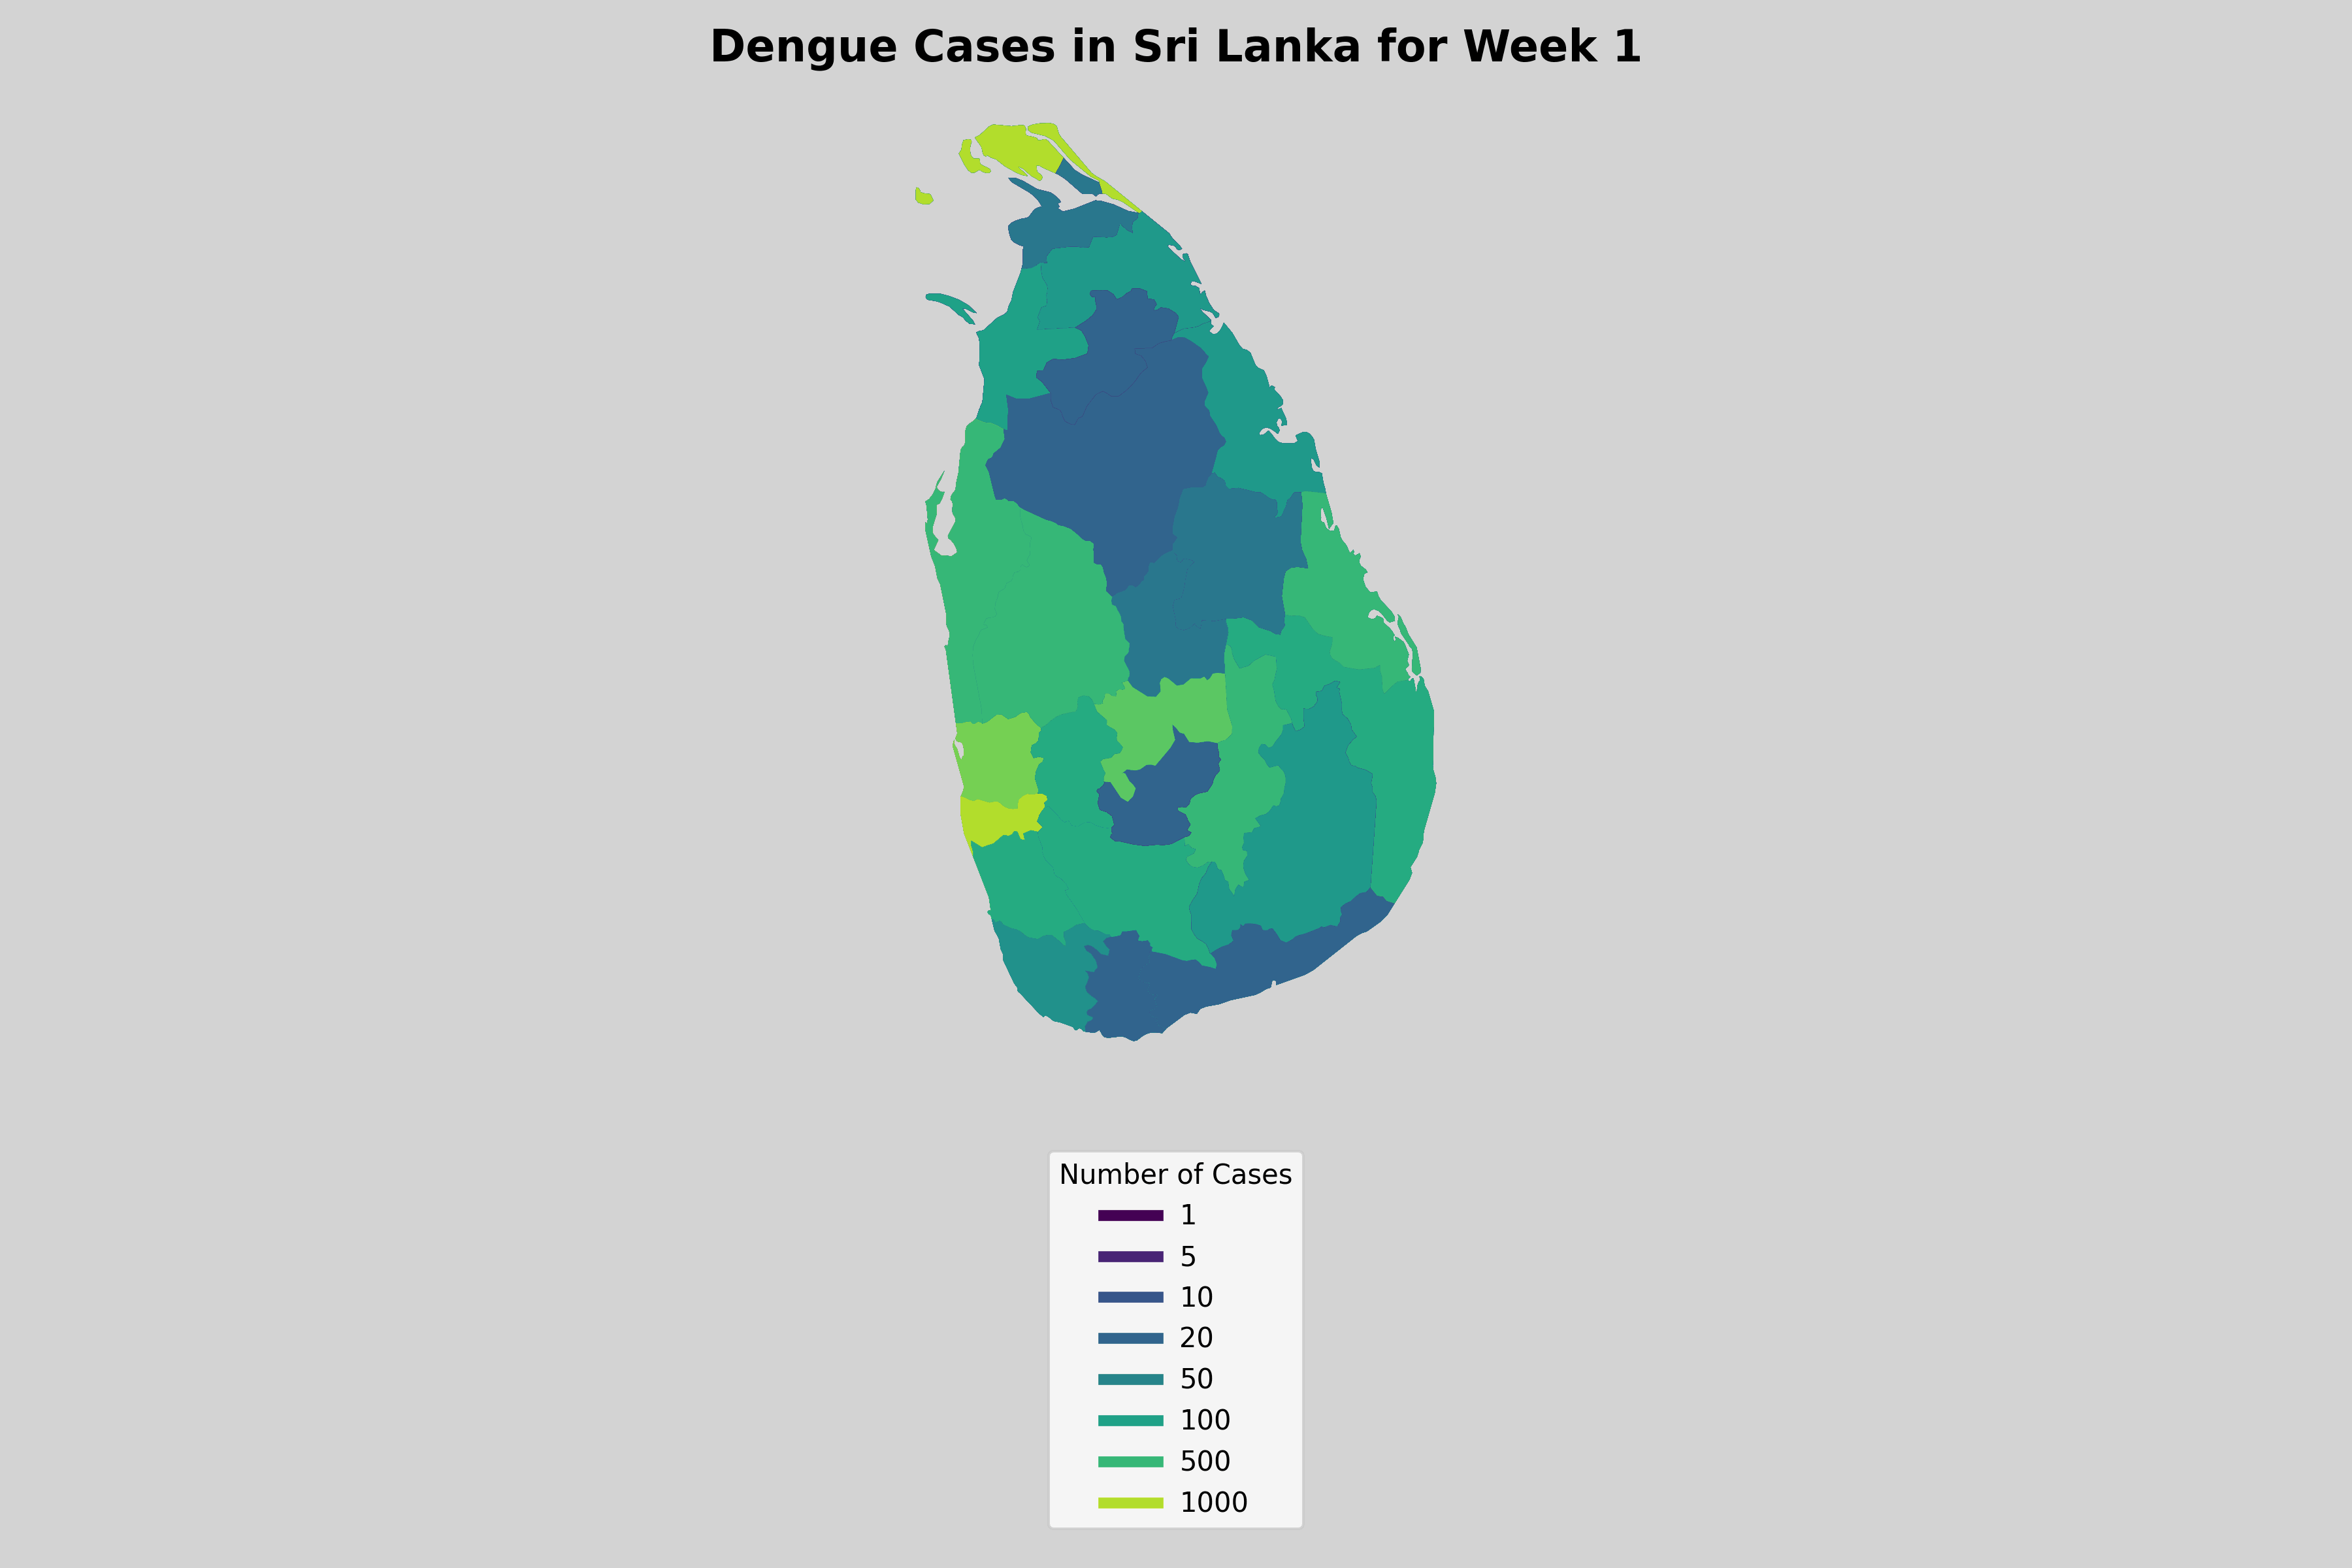

In [88]:
# Load the shapefile using GeoPandas
shapefile_path = 'C:/Users/rajat/SRILANKA DENGUE APP/lk_shp/lk.dbf'
gdf = gpd.read_file(shapefile_path)

# District code mapping based on Sri Lankan district codes
district_code_mapping = {
    "colombo": "LK11", "gampaha": "LK12", "kalutara": "LK13",
    "kandy": "LK21", "matale": "LK22", "nuwara eliya": "LK23",
    "galle": "LK31", "matara": "LK32", "hambantota": "LK33",
    "jaffna": "LK41", "kilinochchi": "LK42", "mannar": "LK43",
    "vavuniya": "LK44", "mullaitivu": "LK45", "batticaloa": "LK51",
    "ampara": "LK52", "trincomalee": "LK53", "kurunegala": "LK61",
    "puttalam": "LK62", "anuradhapura": "LK71", "polonnaruwa": "LK72",
    "badulla": "LK81", "moneragala": "LK82", "ratnapura": "LK91",
    "kegalle": "LK92"
}

# Map district names to district codes in final_data
final_data['district_code'] = final_data['district'].map(district_code_mapping)

# Determine the min and max values for the color scale
min_cases = final_data['Number_of_Cases'].min()
max_cases = final_data['Number_of_Cases'].max()

# Create a directory to store the frames if it doesn't exist
if not os.path.exists('frames'):
    os.makedirs('frames')

# Define the color boundaries for the legend
boundaries = [0, 1, 5, 10, 20, 50, 100, 500, 1000]
labels = [f"{b}" for b in boundaries[1:]]  # Label boundaries

# Generate maps for each week and save them as images
for week in range(1, 54):
    week_data = final_data[final_data['Week'] == week]
    
    # Merge the week data with the geographic data
    merged_week_data = pd.merge(gdf, week_data, how='left', left_on='id', right_on='district_code')

    # Apply logarithmic scaling to the Number of Cases
    merged_week_data['log_cases'] = np.log1p(merged_week_data['Number_of_Cases'])  # Use log1p to avoid log(0)

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Set background colors
    fig.patch.set_facecolor('lightgray')  # figure
    ax.set_facecolor('white')              # axes

    # Plot with fixed color scale using logarithmic values
    merged_week_data.plot(column='log_cases', ax=ax, legend=False,
                          cmap='viridis', vmin=np.log1p(min(boundaries)), vmax=np.log1p(max(boundaries)))

    # Manually create a legend
    custom_lines = [Line2D([0], [0], color=plt.cm.viridis(np.log1p(b) / np.log1p(max(boundaries))), lw=4) for b in boundaries]
    ax.legend(custom_lines, labels, title="Number of Cases", bbox_to_anchor=(0.5, -0.05), loc='upper center')

    # title and axis labels
    plt.title(f'Dengue Cases in Sri Lanka for Week {week}', fontsize=16, fontweight='bold')
    plt.xlabel('Longitude', fontsize=12, fontweight='bold')
    plt.ylabel('Latitude', fontsize=12, fontweight='bold')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # grid
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.axis('off')  # Turn off the axis
    plt.tight_layout()

    # Save the figure
    plt.savefig(f'frames/dengue_cases_week_{week}.png', dpi=300)
    plt.close()

# Create a GIF from the saved images
images = []
for week in range(1, 54):
    image = imageio.imread(f'frames/dengue_cases_week_{week}.png')
    images.append(image)

# Save the GIF with looping enabled and adjusted duration
imageio.mimsave('dengue_cases_animation.gif', images, duration=2.0, loop=0)  # loop=0 means infinite loop

print("Animation saved as dengue_cases_animation.gif")

# Display the animation in the notebook
display(Image(filename='dengue_cases_animation.gif'))



### Insights

1. **Dengue Incidence in Colombo and Surrounding Districts**: The analysis reveals that Colombo and its neighboring districts are consistently experiencing high dengue cases across the weeks. This persistent trend raises questions about the potential for dengue to spread from Colombo to these adjoining areas.

2. **Potential Spread Mechanisms**: The proximity of densely populated urban areas like Colombo to surrounding districts may facilitate the transmission of dengue. Factors such as population mobility, common environmental conditions, and inadequate vector control measures could contribute to the observed pattern of increasing dengue cases in neighboring districts. Furthermore, the movement of individuals infected with the virus, along with mosquitoes capable of transmitting it, can exacerbate the spread.

3. **Exception Cases in Northern and Other Regions**: While Colombo and its vicinity show a steady rise in dengue cases, some exception cases are observed in northern and other regions during different weeks. These anomalies may be attributed to localized outbreaks, variations in climatic conditions, or specific vector breeding sites that differ from those in the Colombo area.

4. **Implications for Public Health**: The insights drawn from this analysis underscore the importance of targeted interventions in both Colombo and neighboring districts to mitigate the spread of dengue. Enhanced vector control measures, public awareness campaigns, and improved surveillance in high-risk areas are essential for effective dengue in Sri Lanka.

# Effect of Lagged Rainfall  on Dengue Cases

Rainfall is widely recognized as a key environmental factor influencing the incidence of mosquito-borne diseases like dengue. Understanding how changes in rainfall affect dengue cases over time is crucial for public health monitoring and preventive measures. In this analysis, we investigate the relationship between dengue cases and lagged rainfall over a span of 15 weeks, using moving averages of total rainfall across all districts.

We aim to identify the lags where rainfall has the strongest correlation with the number of dengue cases, which may help establish a time window for predicting outbreaks based on past rainfall patterns. By calculating correlations for different lag periods and visualizing them, we can assess how rainfall data from earlier weeks contributes to the number of dengue cases observed later.

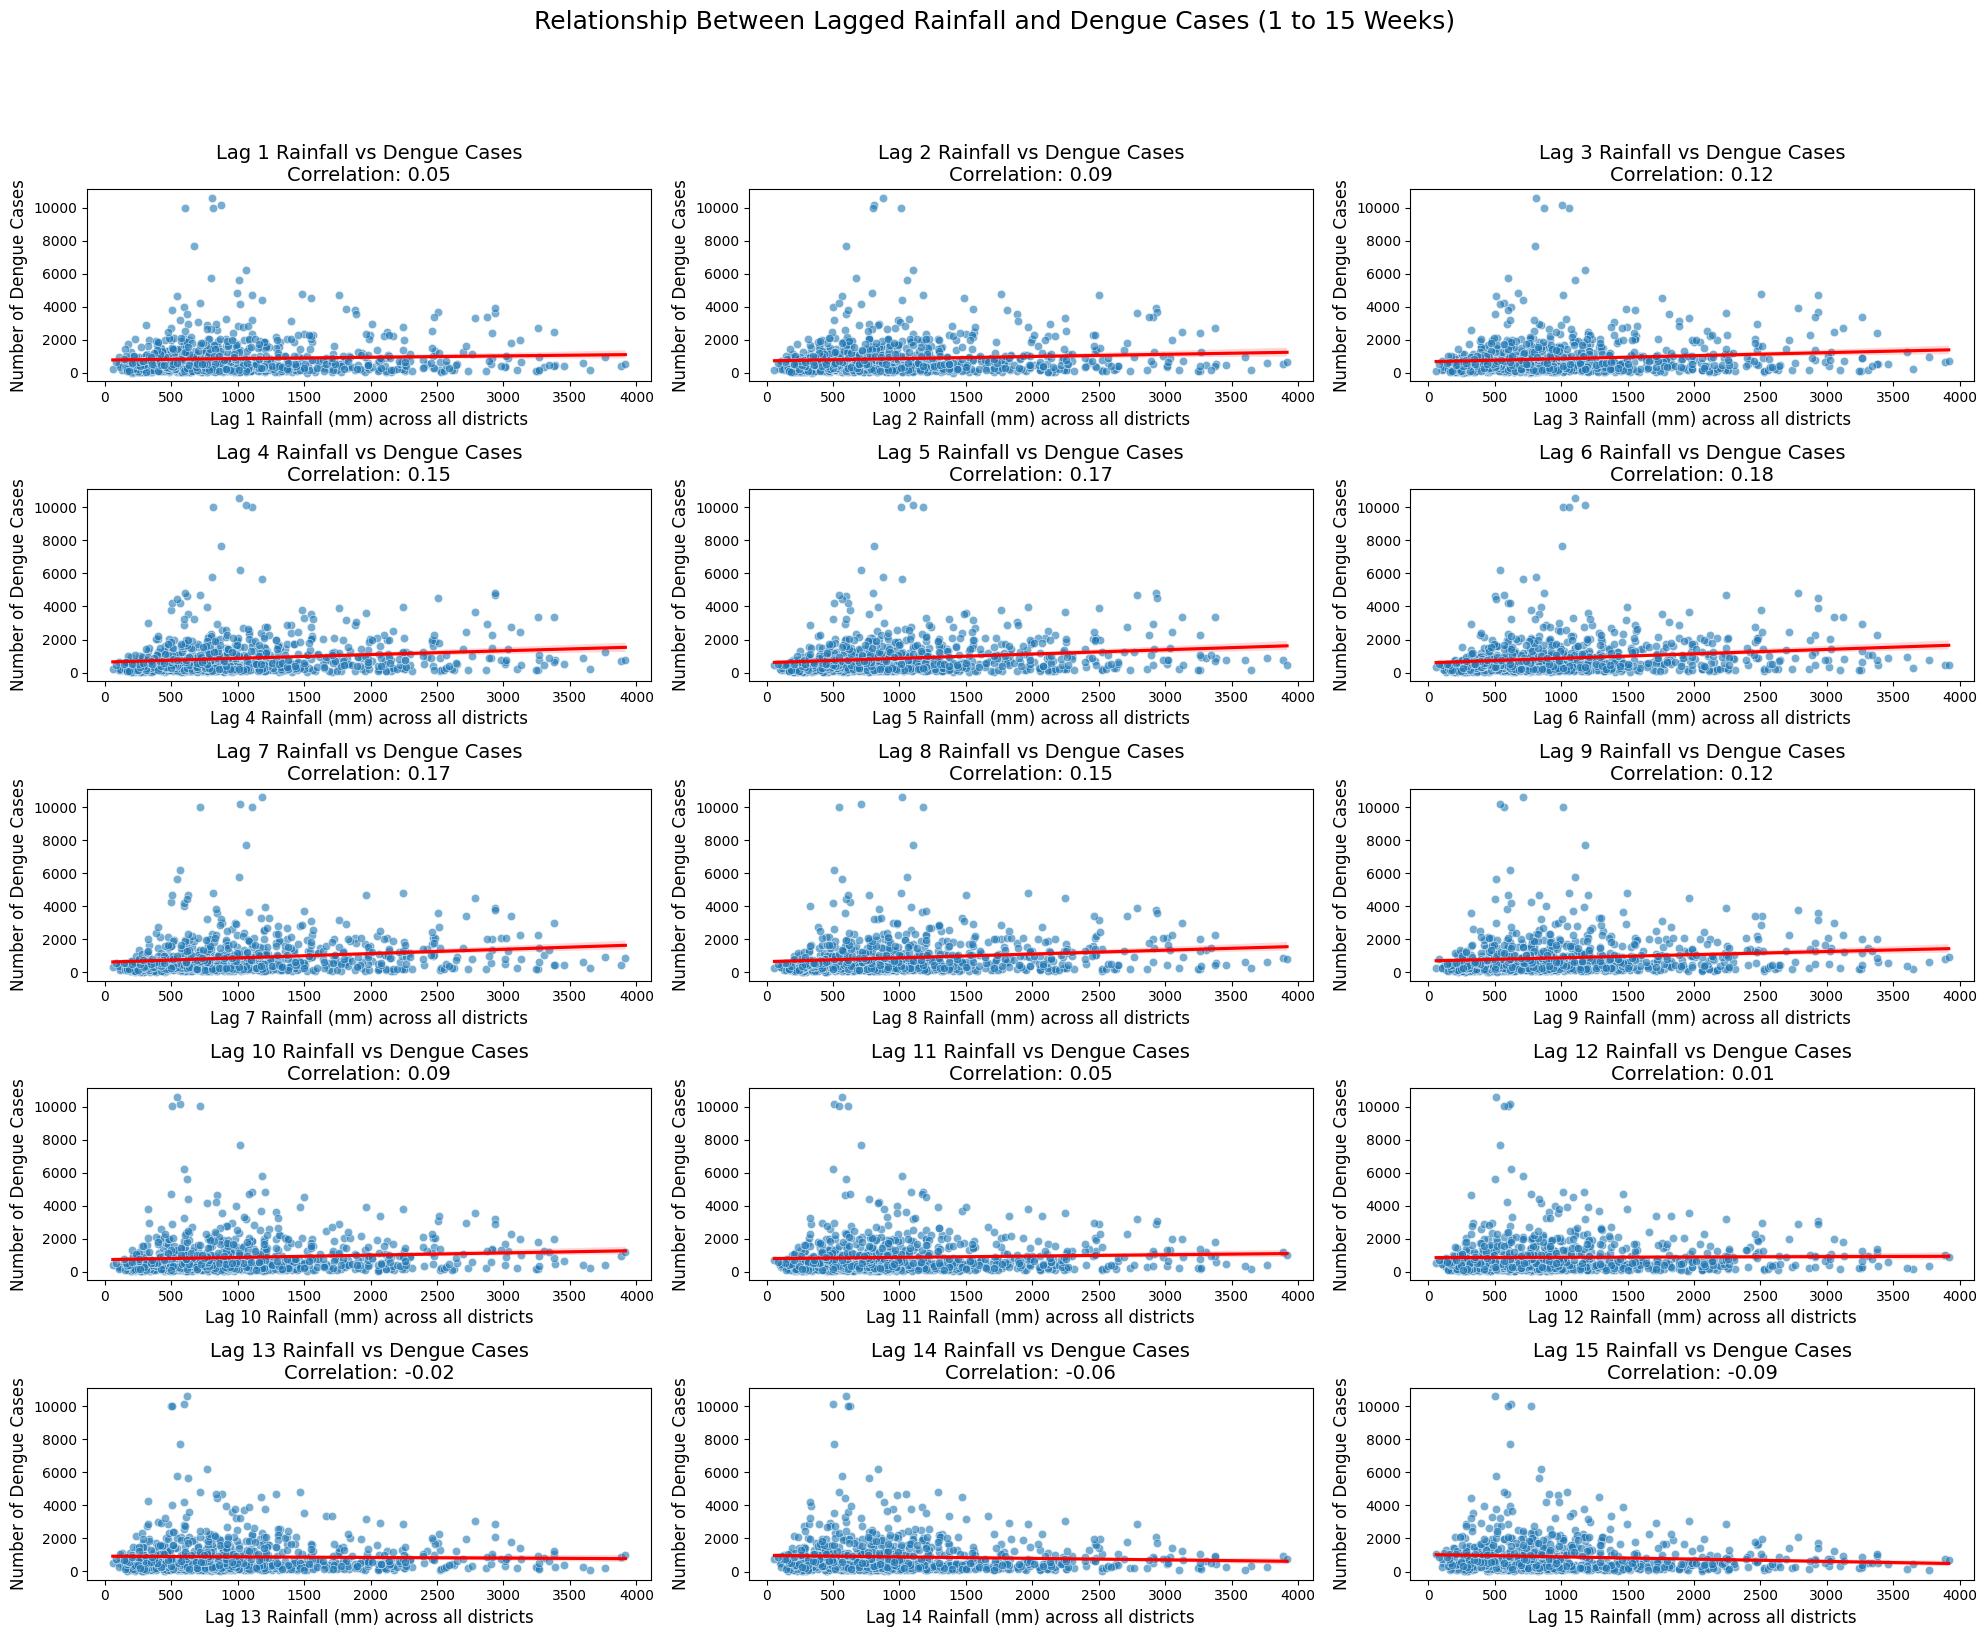

In [25]:
# Group by week and sum the number of cases and total rainfall
weekly_summary = final_data.groupby('Week_Start_Date').agg(
    Number_of_Cases=('Number_of_Cases', 'sum'),
    Total_Rainfall=('Total Rain (mm)', 'sum')
).reset_index()

# Calculate the moving average for rainfall
weekly_summary['Rainfall_Moving_Avg'] = weekly_summary['Total_Rainfall'].rolling(window=4).mean()

# Create lagged rainfall variables from 1 to 15 weeks
for lag in range(1, 16):  # Creating 1-week to 15-weeks lag
    weekly_summary[f'Lag_{lag}_Rainfall'] = weekly_summary['Rainfall_Moving_Avg'].shift(lag)

# Calculate correlation between dengue cases and the new lagged rainfall
correlations_extended = {}
for lag in range(1, 16):
    corr = weekly_summary['Number_of_Cases'].corr(weekly_summary[f'Lag_{lag}_Rainfall'])
    correlations_extended[f'Lag {lag}'] = corr

# Print extended correlation results
#print("Correlation between dengue cases and extended lagged rainfall:")
#for lag, corr in correlations_extended.items():
 #   print(f"{lag}: {corr:.2f}")

# Plotting scatter plots with trend lines for lags
plt.figure(figsize=(20, 16))

for i, lag in enumerate(range(1, 16), start=1):
    plt.subplot(5, 3, i)
    sns.scatterplot(data=weekly_summary, x=f'Lag_{lag}_Rainfall', y='Number_of_Cases', alpha=0.6)
    sns.regplot(data=weekly_summary, x=f'Lag_{lag}_Rainfall', y='Number_of_Cases', scatter=False, color='red')
    
    plt.title(f'Lag {lag} Rainfall vs Dengue Cases\nCorrelation: {correlations_extended[f"Lag {lag}"]:.2f}', fontsize=14)
    plt.xlabel(f'Lag {lag} Rainfall (mm) across all districts', fontsize=12)
    plt.ylabel('Number of Dengue Cases', fontsize=12)

# main title for the entire figure
plt.suptitle('Relationship Between Lagged Rainfall and Dengue Cases (1 to 15 Weeks)', fontsize=18, y=1.02)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

#### Insights

1. **Correlation between Rainfall and Dengue Cases:**
   The correlation between lagged rainfall and dengue cases rises gradually from Lag 1 (0.05) to Lag 6 (0.18), suggesting that rainfall from up to six weeks prior plays a significant role in driving dengue cases. Beyond this point, the correlation starts to decrease, with values tapering off and turning negative by Lag 15 (-0.09). This pattern points to a temporal window, where rainfall within the past 4 to 6 weeks has the strongest influence on dengue cases, while rainfall from earlier periods becomes less relevant.

2. **Reason for Peak at Lag 6 and Decrease Thereafter:**
   The reason for the correlation peaking around Lag 6 and then decreasing could be due to the biological life cycle of mosquitoes and the transmission dynamics of dengue. After a rainfall event, it takes some time for mosquito breeding sites (like stagnant water) to form, for mosquitoes to develop and reach the stage where they can transmit the dengue virus, and for infected individuals to show symptoms.

   - **Mosquito Breeding Cycle:** The mosquito life cycle, from eggs to adults, typically spans about 1 to 2 weeks. After that, an infected mosquito takes another 1 to 2 weeks to bite a human and transmit the virus. This accounts for the increasing correlation seen up to Lag 6, as rainfall from 4 to 6 weeks earlier provides ideal conditions for mosquitoes to breed and start spreading dengue.
   
   - **Decrease After Lag 6:** Once the optimal conditions for mosquito breeding are no longer present (as older stagnant water sources dry up or become less viable), the impact of rainfall from more than 6 weeks earlier starts to diminish. Additionally, mosquitoes may die off naturally, or public health interventions (like insecticide spraying) could reduce their numbers. This explains the declining correlation after Lag 6, as the environmental conditions and mosquito population from earlier rainfall events no longer have a strong effect on dengue transmission.

3. **Visualizing the Relationship:**
   The scatter plots with trend lines for the various lags highlight this pattern. For Lags 5, 6, and 7, the relationship between rainfall and dengue cases is stronger, as reflected in the steeper trend lines. For longer lags, from Lag 10 onwards, the relationship weakens and turns slightly negative, indicating that rainfall from several months prior is no longer a driving factor for current dengue cases.

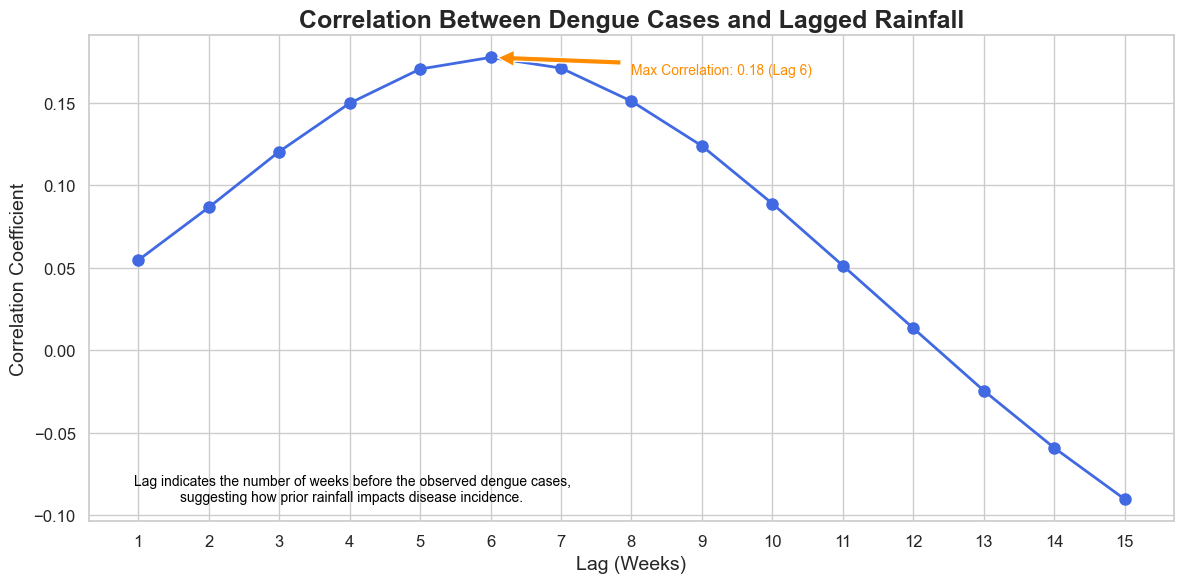

In [26]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the correlation values
plt.plot(range(1, 16), list(correlations_extended.values()), 
         marker='o', color='royalblue', linewidth=2, markersize=8)

# Highlight the maximum correlation point
max_lag = max(correlations_extended, key=correlations_extended.get)
max_corr = correlations_extended[max_lag]
plt.annotate(f'Max Correlation: {max_corr:.2f} (Lag {max_lag.split()[1]})', 
             xy=(6, max_corr), 
             xytext=(8, max_corr - 0.01),
             arrowprops=dict(facecolor='darkorange', shrink=0.05),
             fontsize=10, color='darkorange')

# Title and labels
plt.title('Correlation Between Dengue Cases and Lagged Rainfall', fontsize=18, fontweight='bold')
plt.xlabel('Lag (Weeks)', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)

# Configure ticks and grid
plt.xticks(range(1, 16), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Add a footnote for explanation
plt.figtext(0.3, 0.15, 
             'Lag indicates the number of weeks before the observed dengue cases,\n'
             'suggesting how prior rainfall impacts disease incidence.', 
             ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


#### Conclusion:
The strongest relationship between rainfall and dengue incidence is observed for rainfall events from 4 to 6 weeks prior. Beyond that, the influence diminishes due to the completion of the mosquito life cycle and possibly due to external factors like drying water sources or control measures. Understanding this temporal window is critical for predicting and managing future dengue outbreaks.

# Rainfall and Dengue Correlation in Colombo: A Focused Examination of Lagged Effects
In our ongoing investigation of the relationship between rainfall and dengue cases, we now focus specifically on Colombo, a major district in Sri Lanka, to gain deeper insights into local patterns. This analysis builds on our previous findings, which highlighted a general trend of increasing correlation between rainfall and dengue cases across multiple districts, particularly peaking around 4 to 6 weeks after rainfall events. By examining weekly data, we aim to understand how dengue incidence correlates with lagged rainfall in Colombo, allowing for more targeted public health interventions. This district-specific approach not only highlights the immediate effects of rainfall but also emphasizes the importance of localized modeling in predicting dengue outbreaks.

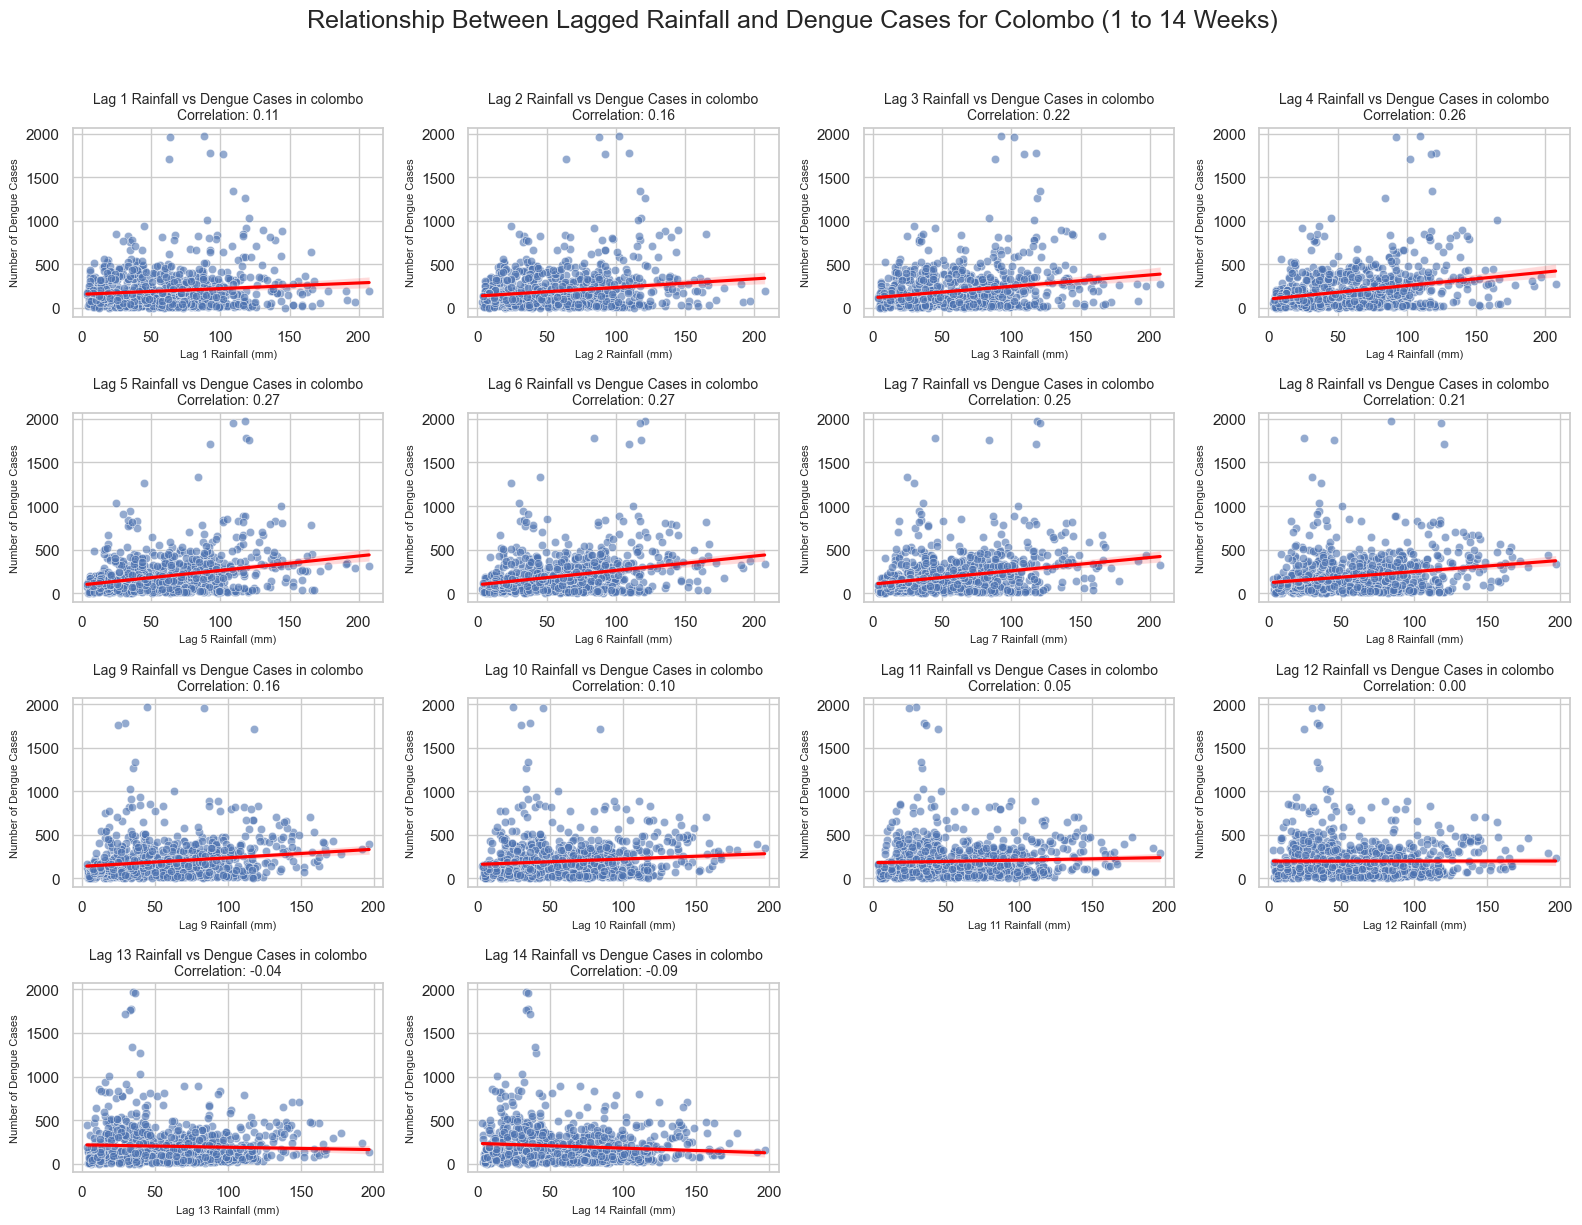

In [27]:
# Group by week and district, summing the number of cases and total rainfall
weekly_summary = final_data.groupby(['Week_Start_Date', 'District']).agg(
    Number_of_Cases=('Number_of_Cases', 'sum'),
    Total_Rainfall=('Total Rain (mm)', 'sum')
).reset_index()

# Specify the district you want to analyze
specific_district = 'colombo'  # district name

# Filter the data for the specific district
district_data = weekly_summary[weekly_summary['District'] == specific_district].copy()

# Calculate the moving average for rainfall using .loc
district_data.loc[:, 'Rainfall_Moving_Avg'] = district_data['Total_Rainfall'].rolling(window=4).mean()

# Create lagged rainfall columns using .loc
for lag in range(1, 15):  # Creating 1-week to 4-weeks lag
    district_data.loc[:, f'Lag_{lag}_Rainfall'] = district_data['Rainfall_Moving_Avg'].shift(lag)

# Calculate correlation between dengue cases and lagged rainfall for the specific district
correlations = {}
for lag in range(1, 15):
    corr = district_data['Number_of_Cases'].corr(district_data[f'Lag_{lag}_Rainfall'])
    correlations[f'Lag {lag}'] = corr

# Print correlation results for the specific district
#print(f"Correlation between dengue cases and lagged rainfall for {specific_district}:")
#for lag, corr in correlations.items():
 #   print(f"{lag}: {corr:.2f}")

plt.figure(figsize=(16, 12))

# all 14 lags
for i, lag in enumerate(range(1, 15), start=1):
    plt.subplot(4, 4, i)  # 14 subplots in a grid (4 rows, 4 columns)
    sns.scatterplot(data=district_data, x=f'Lag_{lag}_Rainfall', y='Number_of_Cases', alpha=0.6)
    sns.regplot(data=district_data, x=f'Lag_{lag}_Rainfall', y='Number_of_Cases', scatter=False, color='red')
    
    plt.title(f'Lag {lag} Rainfall vs Dengue Cases in {specific_district}\nCorrelation: {correlations[f"Lag {lag}"]:.2f}', fontsize=10)
    plt.xlabel(f'Lag {lag} Rainfall (mm)', fontsize=8)
    plt.ylabel('Number of Dengue Cases', fontsize=8)

# main title for the entire figure
plt.suptitle('Relationship Between Lagged Rainfall and Dengue Cases for Colombo (1 to 14 Weeks)', fontsize=18, y=1.02)

plt.tight_layout()
plt.show()

### Insights

1. **Correlation Trend in Colombo:**  
   The correlation between dengue cases and lagged rainfall in Colombo shows a notable increase as the lag period extends from 1 to 4 weeks, peaking at Lag 4 with a correlation of 0.26. This indicates that localized models can effectively capture the dynamics of how rainfall influences dengue transmission in this district.

2. **Sustained Influence of Rainfall:**  
   The correlation remains strong at Lag 5 and Lag 6 (both 0.27), suggesting that conditions created by rainfall continue to contribute to dengue transmission even up to six weeks later. This finding reinforces the idea that district-level analyses are crucial for understanding the specific impacts of rainfall on dengue cases.

3. **Declining Correlation Beyond Six Weeks:**  
   Beyond Lag 6, the correlation values start to decline, with Lag 7 at 0.25 and gradually decreasing to -0.09 by Lag 14. This trend indicates that the influence of rainfall diminishes after a certain period, highlighting the need for district-specific models that can account for local conditions and factors affecting dengue transmission.

4. **Visual Representation of Relationships:**  
   The scatter plots and regression lines for each lag in Colombo visually illustrate the relationships between lagged rainfall and dengue cases. The stronger correlations observed in earlier lags suggest that tailored district models could provide more accurate predictions than generalized models that overlook local dynamics.

5. **Local vs. Aggregate Analysis:**  
   The focus on Colombo allows for a localized understanding of how rainfall impacts dengue incidence. The significant correlations observed at the district level indicate that district-based models may outperform aggregate models in predicting dengue cases, thus enhancing the effectiveness of public health strategies tailored to the unique conditions of the region.

### Conclusion

The analysis of rainfall and dengue cases in Colombo underscores the potential advantages of developing district-specific models. By capturing the localized dynamics of rainfall and dengue transmission, these models can yield more accurate predictions and insights, ultimately informing targeted public health interventions. Understanding these relationships at the district level is essential for effectively responding to potential dengue outbreaks, thereby reducing the burden on affected communities and improving public health outcomes. This localized approach not only enhances predictive accuracy but also aids in implementing tailored strategies that address the unique challenges posed by dengue in different regions.

# Rainfall Patterns and Their Impact on Dengue Incidence

In this analysis, we look into the relationship between rainfall and dengue cases across various districts. We categorize the data into rainfall bins to better understand how different levels of lagged rainfall influence the occurrence of dengue cases. By calculating median values and interquartile ranges (IQR) for dengue cases in relation to specific rainfall thresholds, we aim to identify patterns that could inform public health strategies.

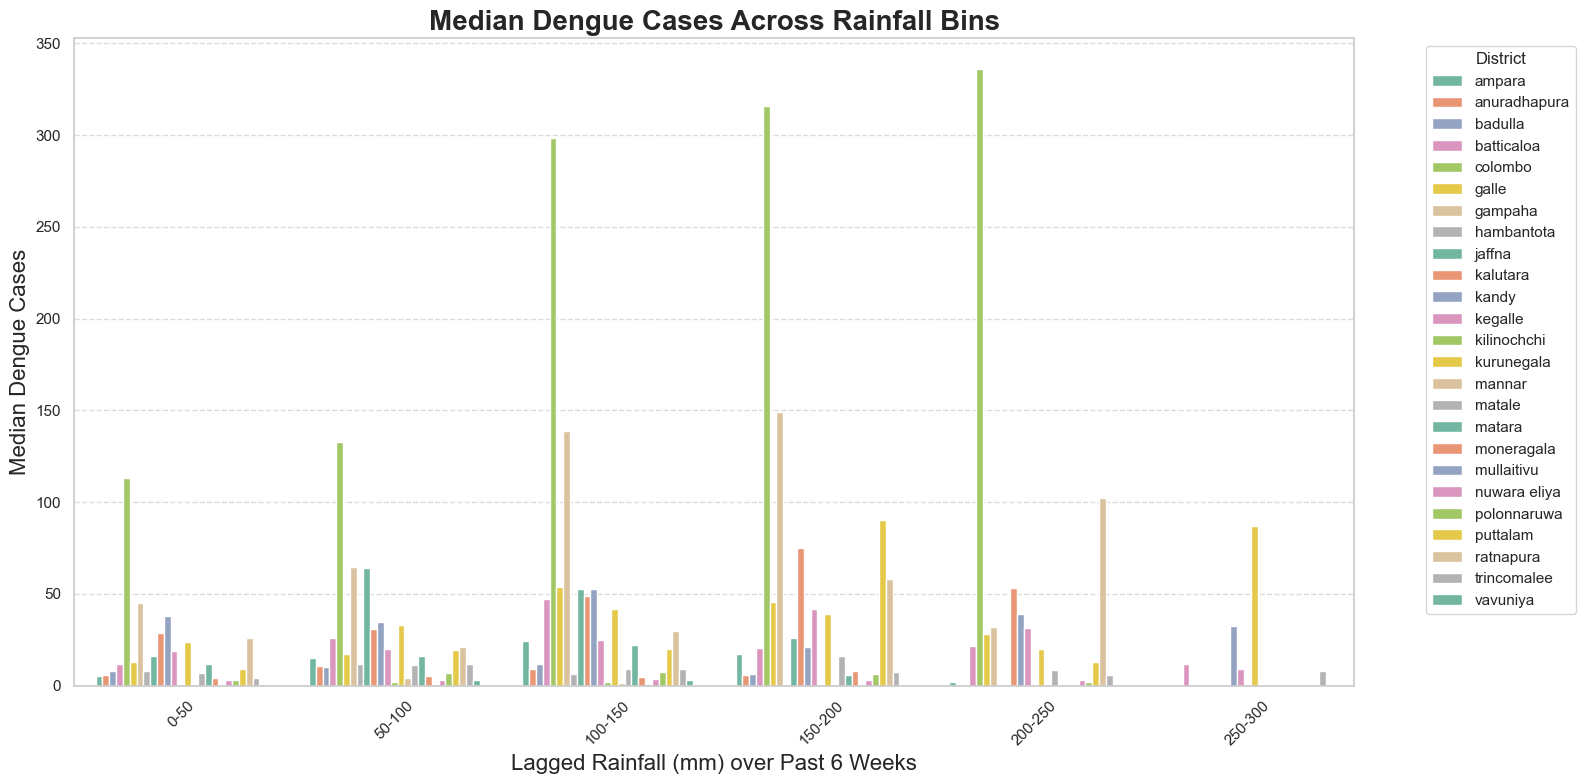

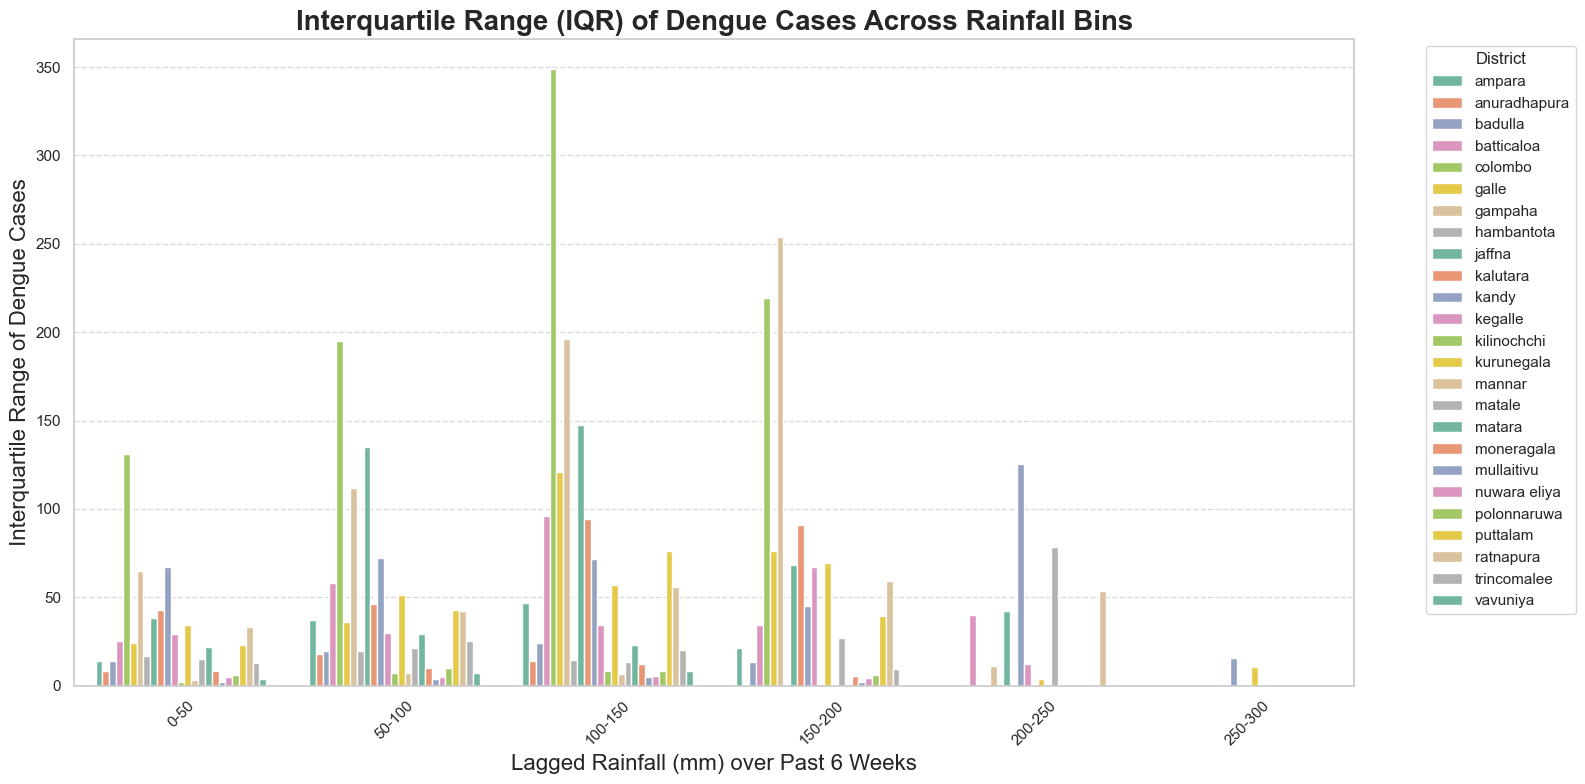

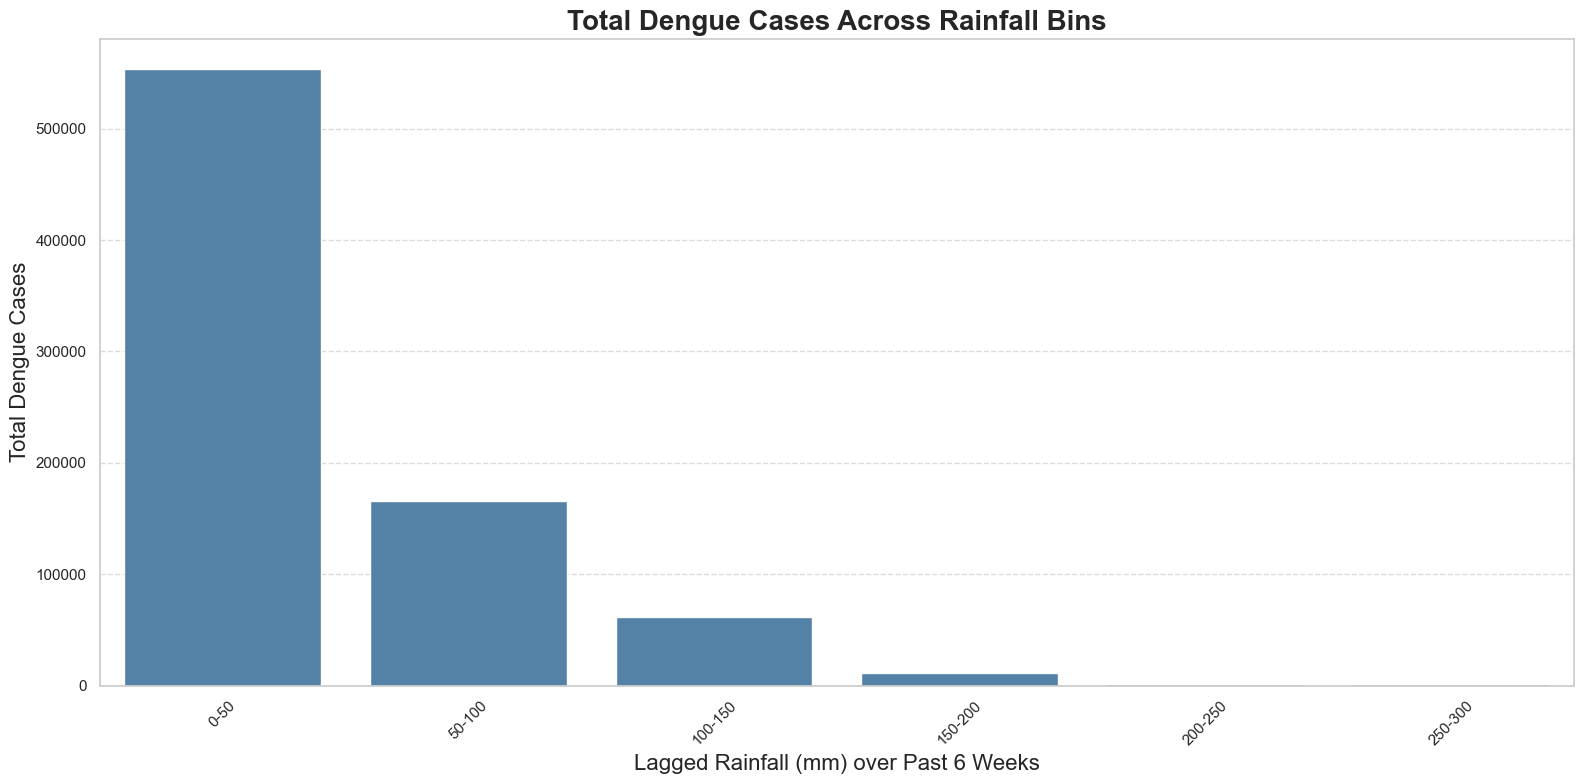

In [28]:
# Get the list of unique districts from the dataset
all_districts = weekly_summary['District'].unique()

# Create bins for rainfall every 50 mm
bins = range(0, 350, 50)
labels = [f'{bins[i]}-{bins[i + 1]}' for i in range(len(bins) - 1)]

# Initialize a list to hold summary statistics for each district
summary_statistics = []

# Loop through all districts and create plots for each
for specific_district in all_districts:
    # Filter the data for the specific district
    district_data = weekly_summary[weekly_summary['District'] == specific_district].copy()
    
    # Calculate moving average and lagged rainfall (Lag 6)
    district_data['Rainfall_Moving_Avg'] = district_data['Total_Rainfall'].rolling(window=4).mean()
    district_data['Lag_6_Rainfall'] = district_data['Rainfall_Moving_Avg'].shift(6)
    
    # Binning the Lag 6 Rainfall data
    district_data['Rainfall_Binned'] = pd.cut(district_data['Lag_6_Rainfall'], bins=bins, labels=labels, include_lowest=True)
    
    # Calculate median, 25th, and 75th percentiles for each rainfall bin
    stats = district_data.groupby('Rainfall_Binned', observed=False)['Number_of_Cases'].agg(
        Median_Cases='median',
        Q1=lambda x: x.quantile(0.25),
        Q3=lambda x: x.quantile(0.75)
    )
    
    # Calculate IQR
    stats['IQR'] = stats['Q3'] - stats['Q1']
    
    # Append district name to the stats DataFrame
    stats['District'] = specific_district
    summary_statistics.append(stats)

# Combine all district statistics into a single DataFrame
summary_statistics_df = pd.concat(summary_statistics).reset_index()

# Print summary statistics 
#print("Summary Statistics for Median Cases and IQR:")
#print(summary_statistics_df)

# Print total counts for each rainfall bin
total_counts = weekly_summary.copy()
total_counts['Rainfall_Moving_Avg'] = total_counts['Total_Rainfall'].rolling(window=4).mean()
total_counts['Lag_6_Rainfall'] = total_counts['Rainfall_Moving_Avg'].shift(6)
total_counts['Rainfall_Binned'] = pd.cut(total_counts['Lag_6_Rainfall'], bins=bins, labels=labels, include_lowest=True)

# Group by rainfall bins and sum the number of cases
total_counts_summary = total_counts.groupby('Rainfall_Binned', observed=False)['Number_of_Cases'].sum().reset_index()

# Print total counts summary 
#print("\nTotal Counts Summary:")
#print(total_counts_summary)

# Set visual style
sns.set(style="whitegrid")

# Plotting the median cases against rainfall bins
plt.figure(figsize=(16, 8))
median_plot = sns.barplot(data=summary_statistics_df, x='Rainfall_Binned', y='Median_Cases', hue='District', palette='Set2', dodge=True)
plt.title('Median Dengue Cases Across Rainfall Bins', fontsize=20, fontweight='bold')
plt.xlabel('Lagged Rainfall (mm) over Past 6 Weeks', fontsize=16)
plt.ylabel('Median Dengue Cases', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot IQR for each rainfall bin
plt.figure(figsize=(16, 8))
iqr_plot = sns.barplot(data=summary_statistics_df, x='Rainfall_Binned', y='IQR', hue='District', palette='Set2', dodge=True)
plt.title('Interquartile Range (IQR) of Dengue Cases Across Rainfall Bins', fontsize=20, fontweight='bold')
plt.xlabel('Lagged Rainfall (mm) over Past 6 Weeks', fontsize=16)
plt.ylabel('Interquartile Range of Dengue Cases', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plotting the total counts against rainfall bins
plt.figure(figsize=(16, 8))
total_count_plot = sns.barplot(data=total_counts_summary, x='Rainfall_Binned', y='Number_of_Cases', color='steelblue')
plt.title('Total Dengue Cases Across Rainfall Bins', fontsize=20, fontweight='bold')
plt.xlabel('Lagged Rainfall (mm) over Past 6 Weeks', fontsize=16)
plt.ylabel('Total Dengue Cases', fontsize=16)
plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Insights

1. **Rainfall Impact on Dengue Cases**: The bar plots depicting median dengue cases against lagged rainfall bins reveal that there is a clear trend in which dengue cases increase with moderate rainfall (50-150 mm), peaking at the 100-150 mm range. This suggests that certain levels of rainfall create ideal breeding conditions for the dengue-carrying Aedes mosquitoes, leading to higher transmission rates.

2. **Interquartile Range Variability**: The IQR plots illustrate variability in dengue cases across different rainfall bins. Notably, as rainfall increases, the IQR reflects significant fluctuations in the number of cases, indicating that while some districts may experience surges in dengue cases with increased rainfall, others may remain unaffected. This variability emphasizes the need for district-specific interventions.

3. **Total Counts and Disease Burden**: The total counts summary indicates that the majority of dengue cases occur at lower rainfall levels, particularly between 0-100 mm. This finding highlights that while high rainfall may create favorable conditions for dengue outbreaks, even minimal rainfall can sustain disease transmission, necessitating ongoing surveillance and proactive measures during all levels of rainfall.

### Conclusion

While moderate rainfall appears to heighten the risk of dengue outbreaks, the observed variability in cases suggests that public health strategies must be tailored to the unique conditions of each district.

---

---